# FibRace Proof Performance Report

A comprehensive analysis of proof generation performance, device characteristics, and crash behaviour across the FibRace dataset.


## Executive Summary

### Global Stats

The proof generation frequency is computed as the number of Cairo M cycles divided by the proof generation duration, it weighs the duration with the computational workload.


| Stat | Value |
| --- | --- | 
| Total Proofs | **1,581,936** |
| Total Players | **5,203** |
| Total Players with at least one proof | **4,427** |
| Total Unique Devices Model | **1,361** |
| Total Cairo M cycles proven | **269,283,832,456** |
| Average Proof Generation Duration (s) | **7.626** |
| Top 10% Proof Generation Duration (s) | **1.468** |
| Top 25% Proof Generation Duration (s) | **3.648** |
| Median Proof Generation Duration (s) | **6.409** |
| Top 75% Proof Generation Duration (s) | **9.531** |
| Top 90% Proof Generation Duration (s) | **14.141** |
| Average Proof Generation Frequency (Hz) | **34,979.172** |
| Median Proof Generation Frequency (Hz) | **13,314.649** |

### RAM Impact on proof generation
Available RAM limits whether or not the proof generation is possible. The minimum RAM a device must have to generate Cairo M proof on FibRace is **3 GB**.
When device is low on available memory, we notice a significative degradation of performance, usually ending up in a crash. On most devices, it is due to continuously generating proofs, which stresses the hardware. Hence, devices with less RAM available tends to prove smaller numbers which yield smaller proof frequencies. Also, devices with lower RAM capacity tends to have slower/older CPUs.

### SoC Impact on proof generation
The proof generation speed is slightly coupled with the CPU architecture and its best core frequency. 


## Dataset Overview

- `snapshot_1m5/mintedItems/`: successful proof generation records (one row per minted proof).
- `snapshot_1m5/players/`: player profiles, including historical best proof stats and minted counters.
- `snapshot_1m5/devices/`: device registrations per player with hardware and OS details.
- `snapshot_1m5/crashLogs/`: reported crashes during proof attempts, capturing player and device identifiers when available.

All timestamps are stored as Unix epoch milliseconds. Numerical performance fields are floating-point values (seconds for duration, Hz for frequency, cycle counts in `n`).


## Environment Setup

This notebook uses `polars` for streaming-friendly analytics and `matplotlib` for visualisations.


In [24]:
from pathlib import Path
from typing import Mapping

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import polars as pl

pl.Config.set_tbl_rows(20)
pl.Config.set_tbl_cols(16)
pl.Config.set_float_precision(3)
pl.Config.set_fmt_str_lengths(512)
pl.Config.set_tbl_width_chars(-1)

plt.style.use("tableau-colorblind10")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.titlesize"] = 12


## Data Access Helpers

Helper utilities encapsulate file-system paths, enforce schemas derived from Convex exports, normalise textual fields, and provide reusable expressions for safe ratios and timestamp conversion.


In [25]:
DATA_ROOT = Path("snapshot_1m5")

MINTED_PATH = DATA_ROOT / "mintedItems" / "documents-filtered.jsonl"
PLAYERS_PATH = DATA_ROOT / "players" / "documents.jsonl"
DEVICES_PATH = DATA_ROOT / "devices" / "documents-enriched.jsonl"
CRASH_PATH = DATA_ROOT / "crashLogs" / "documents.jsonl"

MINTED_SCHEMA: Mapping[str, pl.DataType] = {
    "_creationTime": pl.Float64,
    "_id": pl.Utf8,
    "mintedAt": pl.Float64,
    "n": pl.Float64,
    "overallDuration": pl.Float64,
    "overallFrequency": pl.Float64,
    "playerId": pl.Utf8,
}

PLAYERS_SCHEMA: Mapping[str, pl.DataType] = {
    "_creationTime": pl.Float64,
    "_id": pl.Utf8,
    "bestDuration": pl.Float64,
    "bestDurationN": pl.Float64,
    "bestFrequency": pl.Float64,
    "bestFrequencyN": pl.Float64,
    "createdAt": pl.Float64,
    "mintedCount": pl.Float64,
    "name": pl.Utf8,
    "updatedAt": pl.Float64,
    "userId": pl.Utf8,
}

DEVICES_SCHEMA: Mapping[str, pl.DataType] = {
    "_creationTime": pl.Float64,
    "_id": pl.Utf8,
    "deviceType": pl.Utf8,
    "deviceYearClass": pl.Float64,
    "isDevice": pl.Boolean,
    "manufacturer": pl.Utf8,
    "modelName": pl.Utf8,
    "osName": pl.Utf8,
    "osVersion": pl.Utf8,
    "playerId": pl.Utf8,
    "registeredAt": pl.Float64,
    "totalMemory": pl.Float64,
    "marketingName": pl.Utf8,
    "soc": pl.Utf8,
    "processNm": pl.Float64,
    "bestCoreFreqGHz": pl.Float64,
    "coreDetails": pl.Utf8,
    "releaseDate": pl.Utf8,
}

CRASH_SCHEMA: Mapping[str, pl.DataType] = {
    "_creationTime": pl.Float64,
    "_id": pl.Utf8,
    "deviceId": pl.Utf8,
    "n": pl.Float64,
    "playerId": pl.Utf8,
    "reportedAt": pl.Float64,
}

def scan_jsonl(path: Path, schema: Mapping[str, pl.DataType]) -> pl.LazyFrame:
    if not path.exists():
        raise FileNotFoundError(f"Expected JSONL file missing: {path}")
    return pl.scan_ndjson(
        path.as_posix(),
        schema=schema,
    )

def epoch_ms_to_datetime(column: str, alias: str) -> pl.Expr:
    return (
        pl.when(pl.col(column).is_not_null())
        .then(
            pl.from_epoch(
                pl.col(column).cast(pl.Int64, strict=False),
                time_unit="ms",
            )
        )
        .otherwise(None)
        .alias(alias)
    )

def clean_title(column: str, alias: str) -> pl.Expr:
    return (
        pl.when(pl.col(column).is_not_null())
        .then(
            pl.col(column)
            .cast(pl.Utf8)
            .str.strip_chars()
            .str.replace_all(r"\s+", " ")
            .str.to_titlecase()
        )
        .otherwise(None)
        .alias(alias)
    )

def safe_ratio(numerator: pl.Expr, denominator: pl.Expr, alias: str) -> pl.Expr:
    return (
        pl.when(denominator.is_null() | (denominator == 0))
        .then(None)
        .otherwise(numerator / denominator)
        .alias(alias)
    )

def lf_count(lf: pl.LazyFrame) -> int:
    return lf.select(pl.len().alias("rows")).collect().item()

def lf_scalar(lf: pl.LazyFrame, expr: pl.Expr):
    return lf.select(expr.alias("value")).collect()["value"][0]


## Lazy Dataset Views

Create cached `LazyFrame` objects for each export. These preserve the streaming behaviour of JSONL sources while letting downstream queries reuse common transformations.


In [26]:
minted_lf = (
    scan_jsonl(MINTED_PATH, MINTED_SCHEMA)
    .with_columns([
        pl.col("overallDuration").cast(pl.Float64).alias("overallDuration"),
        pl.col("overallFrequency").cast(pl.Float64).alias("overallFrequency"),
        pl.col("n").cast(pl.Int64).alias("n"),
        pl.col("playerId").cast(pl.Utf8).alias("playerId"),
        epoch_ms_to_datetime("mintedAt", "minted_at"),
        epoch_ms_to_datetime("_creationTime", "created_at"),
    ])
    .with_columns([
        pl.col("minted_at").dt.truncate("1d").alias("minted_date"),
    ])
    .filter(pl.col("playerId").is_not_null())
    .cache()
)

players_lf = (
    scan_jsonl(PLAYERS_PATH, PLAYERS_SCHEMA)
    .with_columns([
        epoch_ms_to_datetime("createdAt", "player_created_at"),
        epoch_ms_to_datetime("updatedAt", "player_updated_at"),
        pl.col("mintedCount").cast(pl.Int32).alias("mintedCount"),
        pl.col("name").cast(pl.Utf8).alias("name"),
    ])
    .cache()
)

devices_lf = (
    scan_jsonl(DEVICES_PATH, DEVICES_SCHEMA)
    .with_columns([
        epoch_ms_to_datetime("registeredAt", "registered_at"),
        clean_title("manufacturer", "manufacturer"),
        pl.col("modelName").cast(pl.Utf8).str.strip_chars().alias("model_name"),
        pl.col("osName").cast(pl.Utf8).alias("os_name"),
        pl.col("osVersion").cast(pl.Utf8).alias("os_version"),
        pl.col("deviceType").cast(pl.Utf8).alias("device_type"),
        pl.col("deviceYearClass").cast(pl.Int16).alias("device_year_class"),
        pl.col("totalMemory").cast(pl.Int64).alias("total_memory_bytes"),
        pl.col("marketingName").cast(pl.Utf8).str.strip_chars().alias("marketing_name"),
        pl.col("soc").cast(pl.Utf8).str.strip_chars().alias("soc"),
        pl.col("processNm").cast(pl.Int8).alias("process_nm"),
        pl.col("bestCoreFreqGHz").cast(pl.Float64).alias("best_core_freq_ghz"),
        pl.col("coreDetails").cast(pl.Utf8).str.strip_chars().alias("core_details"),
        pl.col("releaseDate").cast(pl.Utf8).str.strip_chars().alias("release_date_raw"),
    ])
    .with_columns([
        pl.when(
            pl.col("release_date_raw").is_not_null()
            & (pl.col("release_date_raw") != "")
        )
        .then(pl.col("release_date_raw").str.strptime(pl.Date, "%m/%d/%Y", strict=False))
        .otherwise(None)
        .alias("release_date"),
    ])
    .cache()
)

crash_lf = (
    scan_jsonl(CRASH_PATH, CRASH_SCHEMA)
    .with_columns([
        epoch_ms_to_datetime("reportedAt", "reported_at"),
    ])
    .with_columns([
        pl.col("reported_at").dt.truncate("1d").alias("reported_date"),
    ])
    .cache()
)


### Record Counts & Coverage

Validate row counts and player/device coverage across the exported tables before diving into deeper analysis.


In [27]:
summary_counts = pl.DataFrame(
    {
        "table": ["mintedItems", "players", "devices", "unique devices", "crashLogs"],
        "rows": [
            lf_count(minted_lf),
            lf_count(players_lf),
            lf_count(devices_lf),
            lf_scalar(devices_lf, pl.col("model_name").n_unique()),
            lf_count(crash_lf),
        ],
    }
)

player_coverage = pl.DataFrame(
    {
        "metric": [
            "distinct players with successful proofs",
            "distinct players with crash reports",
        ],
        "value": [
            lf_scalar(minted_lf, pl.col("playerId").n_unique()),
            lf_scalar(crash_lf, pl.col("playerId").drop_nulls().n_unique()),
        ],
    }
)

display(summary_counts)
display(player_coverage)


shape: (5, 2)
┌────────────────┬─────────┐
│ table          ┆ rows    │
│ ---            ┆ ---     │
│ str            ┆ i64     │
╞════════════════╪═════════╡
│ mintedItems    ┆ 1581936 │
│ players        ┆ 5203    │
│ devices        ┆ 5180    │
│ unique devices ┆ 1361    │
│ crashLogs      ┆ 11677   │
└────────────────┴─────────┘

shape: (2, 2)
┌─────────────────────────────────────────┬───────┐
│ metric                                  ┆ value │
│ ---                                     ┆ ---   │
│ str                                     ┆ i64   │
╞═════════════════════════════════════════╪═══════╡
│ distinct players with successful proofs ┆ 4427  │
│ distinct players with crash reports     ┆ 3119  │
└─────────────────────────────────────────┴───────┘

## Global Activity & Reliability Trends

High-level KPIs describing throughput, performance, and reliability provide quick sanity checks and context for deeper slices.


In [28]:
global_metrics_row = (
    minted_lf
    .select([
        pl.len().alias("minted_proofs"),
        pl.col("playerId").n_unique().alias("unique_players"),
        pl.col("n").sum().mul(8).alias("total_cycles"),
        pl.col("overallDuration").mean().alias("avg_duration_s"),
        pl.col("overallDuration").quantile(0.10).alias("p10_duration_s"),
        pl.col("overallDuration").quantile(0.25).alias("p25_duration_s"),
        pl.col("overallDuration").median().alias("median_duration_s"),
        pl.col("overallDuration").quantile(0.75).alias("p75_duration_s"),
        pl.col("overallDuration").quantile(0.90).alias("p90_duration_s"),
        pl.col("overallFrequency").mean().alias("avg_frequency_hz"),
        pl.col("overallFrequency").median().alias("median_frequency_hz"),
    ])
    .collect()
    .row(0, named=True)
)

global_metric_values = [
    float(value) if isinstance(value, (int, float)) else value
    for value in global_metrics_row.values()
]

global_metrics_table = pl.DataFrame(
    {
        "metric": list(global_metrics_row.keys()),
        "value": pl.Series(name="value", values=global_metric_values, dtype=pl.Float64),
    }
)

crash_metrics_row = (
    crash_lf
    .select([
        pl.len().alias("crash_events"),
        pl.col("playerId").drop_nulls().n_unique().alias("players_with_crash"),
        pl.col("deviceId").drop_nulls().n_unique().alias("devices_with_crash"),
    ])
    .collect()
    .row(0, named=True)
)

crash_metrics_table = pl.DataFrame(
    {
        "metric": list(crash_metrics_row.keys()),
        "value": list(crash_metrics_row.values()),
    }
)

minted_players_df = minted_lf.select(pl.col("playerId")).unique().collect()
crash_players_df = crash_lf.select(pl.col("playerId").drop_nulls().alias("playerId")).unique().collect()
players_with_both = minted_players_df.join(crash_players_df, on="playerId", how="inner").height

cohort_overlap = pl.DataFrame(
    {
        "metric": ["players present in both minted and crash logs"],
        "value": [players_with_both],
    }
)

display(global_metrics_table)
display(crash_metrics_table)
display(cohort_overlap)


shape: (11, 2)
┌─────────────────────┬──────────────────┐
│ metric              ┆ value            │
│ ---                 ┆ ---              │
│ str                 ┆ f64              │
╞═════════════════════╪══════════════════╡
│ minted_proofs       ┆ 1581936.000      │
│ unique_players      ┆ 4427.000         │
│ total_cycles        ┆ 269283832456.000 │
│ avg_duration_s      ┆ 7.626            │
│ p10_duration_s      ┆ 1.468            │
│ p25_duration_s      ┆ 3.648            │
│ median_duration_s   ┆ 6.409            │
│ p75_duration_s      ┆ 9.531            │
│ p90_duration_s      ┆ 14.141           │
│ avg_frequency_hz    ┆ 34979.172        │
│ median_frequency_hz ┆ 13314.649        │
└─────────────────────┴──────────────────┘

shape: (3, 2)
┌────────────────────┬───────┐
│ metric             ┆ value │
│ ---                ┆ ---   │
│ str                ┆ i64   │
╞════════════════════╪═══════╡
│ crash_events       ┆ 11677 │
│ players_with_crash ┆ 3119  │
│ devices_with_crash ┆ 3106  │
└────────────────────┴───────┘

shape: (1, 2)
┌───────────────────────────────────────────────┬───────┐
│ metric                                        ┆ value │
│ ---                                           ┆ ---   │
│ str                                           ┆ i64   │
╞═══════════════════════════════════════════════╪═══════╡
│ players present in both minted and crash logs ┆ 2778  │
└───────────────────────────────────────────────┴───────┘

## Player-Level Performance

Aggregate successful proofs per player to benchmark throughput, proving speed, and frequency.


In [29]:
player_perf = (
    minted_lf
    .group_by("playerId")
    .agg([
        pl.len().alias("proof_count"),
        pl.col("n").mean().alias("avg_n"),
        pl.col("n").max().alias("max_n"),
        pl.col("overallDuration").mean().alias("avg_duration_s"),
        pl.col("overallDuration").quantile(0.1).alias("p10_duration_s"),
        pl.col("overallDuration").median().alias("median_duration_s"),
        pl.col("overallDuration").quantile(0.9).alias("p90_duration_s"),
        pl.col("overallFrequency").quantile(0.1).alias("p10_frequency_hz"),
        pl.col("overallFrequency").mean().alias("avg_frequency_hz"),
        pl.col("overallFrequency").median().alias("median_frequency_hz"),
        pl.col("overallFrequency").quantile(0.9).alias("p90_frequency_hz"),
        pl.col("minted_at").min().alias("first_mint_at"),
        pl.col("minted_at").max().alias("last_mint_at"),
    ])
    .collect()
    .with_columns([
        pl.col("proof_count").cast(pl.Int64),
    ])
)

player_reference = (
    players_lf
    .select([
        pl.col("_id").alias("playerId"),
        pl.col("mintedCount").alias("reported_minted_count"),
        pl.col("bestDuration").alias("best_duration_s"),
        pl.col("bestDurationN").alias("best_duration_n"),
        pl.col("bestFrequency").alias("best_frequency_hz"),
        pl.col("bestFrequencyN").alias("best_frequency_n"),
        pl.col("player_created_at"),
    ])
    .collect()
)

device_latest = (
    devices_lf
    .group_by("playerId")
    .agg([
        pl.col("_id").sort_by("registered_at", descending=True).first().alias("deviceId"),
        pl.col("registered_at").sort_by("registered_at", descending=True).first().alias("registered_at"),
        pl.col("manufacturer").sort_by("registered_at", descending=True).first().alias("manufacturer"),
        pl.col("model_name").sort_by("registered_at", descending=True).first().alias("model_name"),
        pl.col("os_name").sort_by("registered_at", descending=True).first().alias("os_name"),
        pl.col("os_version").sort_by("registered_at", descending=True).first().alias("os_version"),
        pl.col("device_type").sort_by("registered_at", descending=True).first().alias("device_type"),
        pl.col("device_year_class").sort_by("registered_at", descending=True).first().alias("device_year_class"),
        pl.col("total_memory_bytes").sort_by("registered_at", descending=True).first().alias("total_memory_bytes"),
        pl.col("marketing_name").sort_by("registered_at", descending=True).first().alias("marketing_name"),
        pl.col("soc").sort_by("registered_at", descending=True).first().alias("soc"),
        pl.col("process_nm").sort_by("registered_at", descending=True).first().alias("process_nm"),
        pl.col("best_core_freq_ghz").sort_by("registered_at", descending=True).first().alias("best_core_freq_ghz"),
        pl.col("core_details").sort_by("registered_at", descending=True).first().alias("core_details"),
        pl.col("release_date").sort_by("registered_at", descending=True).first().alias("release_date"),
        pl.col("release_date_raw").sort_by("registered_at", descending=True).first().alias("release_date_raw"),
    ])
    .collect()
)

player_perf_enriched = (
    player_perf.join(player_reference, on="playerId", how="left")
    .join(device_latest, on="playerId", how="left")
    .sort("proof_count", descending=True)
)

player_perf_enriched.head(3)


shape: (3, 36)
┌──────────────────────────────────┬─────────────┬───────────┬───────┬────────────────┬────────────────┬───────────────────┬────────────────┬───┬────────────────────┬──────────────────────────┬───────────────────────────────────────┬────────────┬────────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────┬──────────────┬──────────────────┐
│ playerId                         ┆ proof_count ┆ avg_n     ┆ max_n ┆ avg_duration_s ┆ p10_duration_s ┆ median_duration_s ┆ p90_duration_s ┆ … ┆ total_memory_bytes ┆ marketing_name           ┆ soc                                   ┆ process_nm ┆ best_core_freq_ghz ┆ core_details                                                                                 ┆ release_date ┆ release_date_raw │
│ ---                              ┆ ---         ┆ ---       ┆ ---   ┆ ---            ┆ ---            ┆ ---               ┆ ---            ┆   ┆ ---                ┆ ---                      ┆ ---                                   ┆ ---        ┆ ---                ┆ ---                                                                                          ┆ ---          ┆ ---              │
│ str                              ┆ i64         ┆ f64       ┆ i64   ┆ f64            ┆ f64            ┆ f64               ┆ f64            ┆   ┆ i64                ┆ str                      ┆ str                                   ┆ i8         ┆ f64                ┆ str                                                                                          ┆ date         ┆ str              │
╞══════════════════════════════════╪═════════════╪═══════════╪═══════╪════════════════╪════════════════╪═══════════════════╪════════════════╪═══╪════════════════════╪══════════════════════════╪═══════════════════════════════════════╪════════════╪════════════════════╪══════════════════════════════════════════════════════════════════════════════════════════════╪══════════════╪══════════════════╡
│ kd701rtqtyxjm00ghq2c2r6r6s7qcd3g ┆ 27345       ┆ 18130.067 ┆ 99894 ┆ 7.533          ┆ 6.424          ┆ 7.355             ┆ 8.894          ┆ … ┆ 11932553216        ┆ OnePlus Nord CE 5G       ┆ Qualcomm SM7225 Snapdragon 750G 5G    ┆ 8          ┆ 2.200              ┆ 2x2.2 GHz Kryo 570 & 6x1.8 GHz Kryo 570                                                      ┆ 2021-06-10   ┆ 06/10/2021       │
│ kd71hnx94q5mm57ndcx56a99c97qcdfe ┆ 22809       ┆ 39127.230 ┆ 99994 ┆ 2.718          ┆ 2.029          ┆ 2.592             ┆ 3.389          ┆ … ┆ 16131203072        ┆ Oppo Find X8             ┆ Mediatek Dimensity 9400               ┆ 3          ┆ 3.630              ┆ 1x3.63 GHz Cortex-X925 & 3x3.3 GHz Cortex-X4 & 4x2.4 GHz Cortex-A720                         ┆ 2024-10-24   ┆ 10/24/2024       │
│ kd706xjft83ryp6j2cfv1ad6cs7qf81j ┆ 13896       ┆ 8840.584  ┆ 99922 ┆ 5.336          ┆ 2.858          ┆ 5.944             ┆ 6.946          ┆ … ┆ 11582689280        ┆ Samsung Galaxy S23 Ultra ┆ Qualcomm SM8550-AC Snapdragon 8 Gen 2 ┆ 4          ┆ 3.360              ┆ 1x3.36 GHz Cortex-X3 & 2x2.8 GHz Cortex-A715 & 2x2.8 GHz Cortex-A710 & 3x2.0 GHz Cortex-A510 ┆ 2023-02-01   ┆ 02/01/2023       │
└──────────────────────────────────┴─────────────┴───────────┴───────┴────────────────┴────────────────┴───────────────────┴────────────────┴───┴────────────────────┴──────────────────────────┴───────────────────────────────────────┴────────────┴────────────────────┴──────────────────────────────────────────────────────────────────────────────────────────────┴──────────────┴──────────────────┘

### Fastest And Slowest Cohorts

Compare players with at least five proofs to highlight best-in-class devices and outliers needing deeper investigation.


In [45]:
minimum_proofs = 4

fastest_players = (
    player_perf_enriched
    .filter(pl.col("proof_count") >= minimum_proofs)
    .sort("median_duration_s")
    .select([
        "playerId",
        "marketing_name",
        "proof_count",
        "median_duration_s",
        "avg_duration_s",
        "p90_duration_s",
        "avg_frequency_hz",
        "reported_minted_count",
        "best_duration_s",
    ])
    .head(10)
)

slowest_players = (
    player_perf_enriched
    .filter(pl.col("proof_count") >= minimum_proofs)
    .sort("median_duration_s", descending=True)
    .select([
        "playerId",
        "marketing_name",
        "proof_count",
        "median_duration_s",
        "avg_duration_s",
        "p90_duration_s",
        "avg_frequency_hz",
        "reported_minted_count",
        "best_duration_s",
    ])
    .head(10)
)

display(fastest_players)
display(slowest_players)


shape: (10, 9)
┌──────────────────────────────────┬──────────────────────────┬─────────────┬───────────────────┬────────────────┬────────────────┬──────────────────┬───────────────────────┬─────────────────┐
│ playerId                         ┆ marketing_name           ┆ proof_count ┆ median_duration_s ┆ avg_duration_s ┆ p90_duration_s ┆ avg_frequency_hz ┆ reported_minted_count ┆ best_duration_s │
│ ---                              ┆ ---                      ┆ ---         ┆ ---               ┆ ---            ┆ ---            ┆ ---              ┆ ---                   ┆ ---             │
│ str                              ┆ str                      ┆ i64         ┆ f64               ┆ f64            ┆ f64            ┆ f64              ┆ i32                   ┆ f64             │
╞══════════════════════════════════╪══════════════════════════╪═════════════╪═══════════════════╪════════════════╪════════════════╪══════════════════╪═══════════════════════╪═════════════════╡
│ kd78tr4qw6bwjvrwf1scj05fm17qg0m2 ┆ Apple iPad Pro 11 (2024) ┆ 3305        ┆ 0.689             ┆ 0.719          ┆ 0.894          ┆ 152965.449       ┆ 3305                  ┆ 0.578           │
│ kd7bt5kekresn42904tqcpgwps7qqygf ┆ Apple iPad Air (2022)    ┆ 2810        ┆ 0.879             ┆ 0.976          ┆ 1.213          ┆ 70359.717        ┆ 2810                  ┆ 0.812           │
│ kd7dyh31kpyemzdqbebtmh9pg57qcg9k ┆ Apple iPhone 16 Pro      ┆ 155         ┆ 0.880             ┆ 0.934          ┆ 1.093          ┆ 29301.884        ┆ 155                   ┆ 0.848           │
│ kd73j482mn12zcf7b1wrs5vs1n7qe8xg ┆ Apple iPhone 16          ┆ 349         ┆ 0.890             ┆ 0.899          ┆ 0.933          ┆ 6875.200         ┆ 349                   ┆ 0.850           │
│ kd7e374xtwcckkydq9ybf1qf1h7qf2z8 ┆ Apple iPhone 16 Pro      ┆ 269         ┆ 0.891             ┆ 0.989          ┆ 1.280          ┆ 40955.146        ┆ 269                   ┆ 0.861           │
│ kd77hdpjjv9q66henpmg6cvs9h7qg9e5 ┆ Apple iPad Pro 11 (2024) ┆ 439         ┆ 0.897             ┆ 0.904          ┆ 1.187          ┆ 347320.203       ┆ 439                   ┆ 0.591           │
│ kd7eaab0hh6tpw198frbqwybz57qfqz2 ┆ Apple iPhone 16 Pro      ┆ 479         ┆ 0.900             ┆ 0.950          ┆ 0.986          ┆ 22936.070        ┆ 479                   ┆ 0.836           │
│ kd7cg7dn5c1za2en4bk8hfr14x7qdg5g ┆ Apple iPhone 16 Pro      ┆ 47          ┆ 0.907             ┆ 1.015          ┆ 1.293          ┆ 58706.255        ┆ 47                    ┆ 0.883           │
│ kd7bycz6cxw7kv769v6r0f25157qdnbb ┆ Apple iPad Pro 11 (2024) ┆ 41          ┆ 0.910             ┆ 0.951          ┆ 1.207          ┆ 350615.899       ┆ 41                    ┆ 0.599           │
│ kd74wkgjh0c13a2n75k4g693257qcfk4 ┆ Apple iPhone 16          ┆ 1158        ┆ 0.917             ┆ 1.073          ┆ 1.364          ┆ 90820.068        ┆ 1158                  ┆ 0.850           │
└──────────────────────────────────┴──────────────────────────┴─────────────┴───────────────────┴────────────────┴────────────────┴──────────────────┴───────────────────────┴─────────────────┘

shape: (10, 9)
┌──────────────────────────────────┬─────────────────────────┬─────────────┬───────────────────┬────────────────┬────────────────┬──────────────────┬───────────────────────┬─────────────────┐
│ playerId                         ┆ marketing_name          ┆ proof_count ┆ median_duration_s ┆ avg_duration_s ┆ p90_duration_s ┆ avg_frequency_hz ┆ reported_minted_count ┆ best_duration_s │
│ ---                              ┆ ---                     ┆ ---         ┆ ---               ┆ ---            ┆ ---            ┆ ---              ┆ ---                   ┆ ---             │
│ str                              ┆ str                     ┆ i64         ┆ f64               ┆ f64            ┆ f64            ┆ f64              ┆ i32                   ┆ f64             │
╞══════════════════════════════════╪═════════════════════════╪═════════════╪═══════════════════╪════════════════╪════════════════╪══════════════════╪═══════════════════════╪═════════════════╡
│ kd750srd3zpsagcrmtf8tm83gs7qk6q5 ┆ Samsung Galaxy A14 5G   ┆ 24          ┆ 82.821            ┆ 78.734         ┆ 94.974         ┆ 775.563          ┆ 24                    ┆ 39.559          │
│ kd710j7nav7949a8gr2z3epkdh7qd4sq ┆ Infinix Smart 7 (India) ┆ 43          ┆ 70.970            ┆ 70.375         ┆ 89.525         ┆ 5628.897         ┆ 43                    ┆ 28.958          │
│ kd7254ps8jr08pbvvydy6qbr8s7qf03c ┆ Apple iPhone XS Max     ┆ 19          ┆ 69.797            ┆ 69.048         ┆ 95.076         ┆ 5937.962         ┆ 19                    ┆ 4.010           │
│ kd71bgkh8k22kd07q21sxj8rvs7qmzn6 ┆ Xiaomi Redmi 12 5G      ┆ 193         ┆ 55.844            ┆ 60.927         ┆ 93.604         ┆ 5051.564         ┆ 193                   ┆ 25.335          │
│ kd7bthphj6n04ark3zxqbnvmrx7qs91n ┆ Samsung Galaxy A04      ┆ 36          ┆ 55.019            ┆ 55.192         ┆ 72.960         ┆ 3422.055         ┆ 36                    ┆ 34.286          │
│ kd7cxyh05x11gxybw18dd6n7j97r0h2c ┆ Apple iPhone XS Max     ┆ 11          ┆ 50.207            ┆ 47.676         ┆ 59.733         ┆ 5671.015         ┆ 11                    ┆ 10.367          │
│ kd7c8p413w05hyp41g5b9vr2cd7qf7tw ┆ Apple iPhone X          ┆ 69          ┆ 46.603            ┆ 100.872        ┆ 62.291         ┆ 2821.875         ┆ 69                    ┆ 4.377           │
│ kd78agygn101vhgzfhhph5h0ds7qs892 ┆ Infinix Hot 30 Play NFC ┆ 5           ┆ 41.197            ┆ 42.430         ┆ 57.296         ┆ 14803.210        ┆ 5                     ┆ 28.560          │
│ kd7etc4j7w3d2msv89f673vg857qrjpk ┆ Infinix Hot 12i         ┆ 4           ┆ 40.428            ┆ 42.725         ┆ 54.251         ┆ 4074.920         ┆ 4                     ┆ 35.792          │
│ kd77a6apsb984y7hxbnnhbhkrh7qvwpe ┆ Xiaomi Redmi A3x        ┆ 115         ┆ 39.199            ┆ 42.834         ┆ 58.083         ┆ 1183.593         ┆ 115                   ┆ 20.422          │
└──────────────────────────────────┴─────────────────────────┴─────────────┴───────────────────┴────────────────┴────────────────┴──────────────────┴───────────────────────┴─────────────────┘

### Performance Distributions & Frequency Relationship


In [46]:
player_distribution_df = player_perf_enriched.select([
    "avg_duration_s",
    "avg_frequency_hz",
    "proof_count",
]).drop_nulls()


#### Outlier-Clipped View
Focusing on the central 99% of players (0.05th – 99.5th percentiles) highlights the bulk 
behaviour without extreme devices skewing the scale.


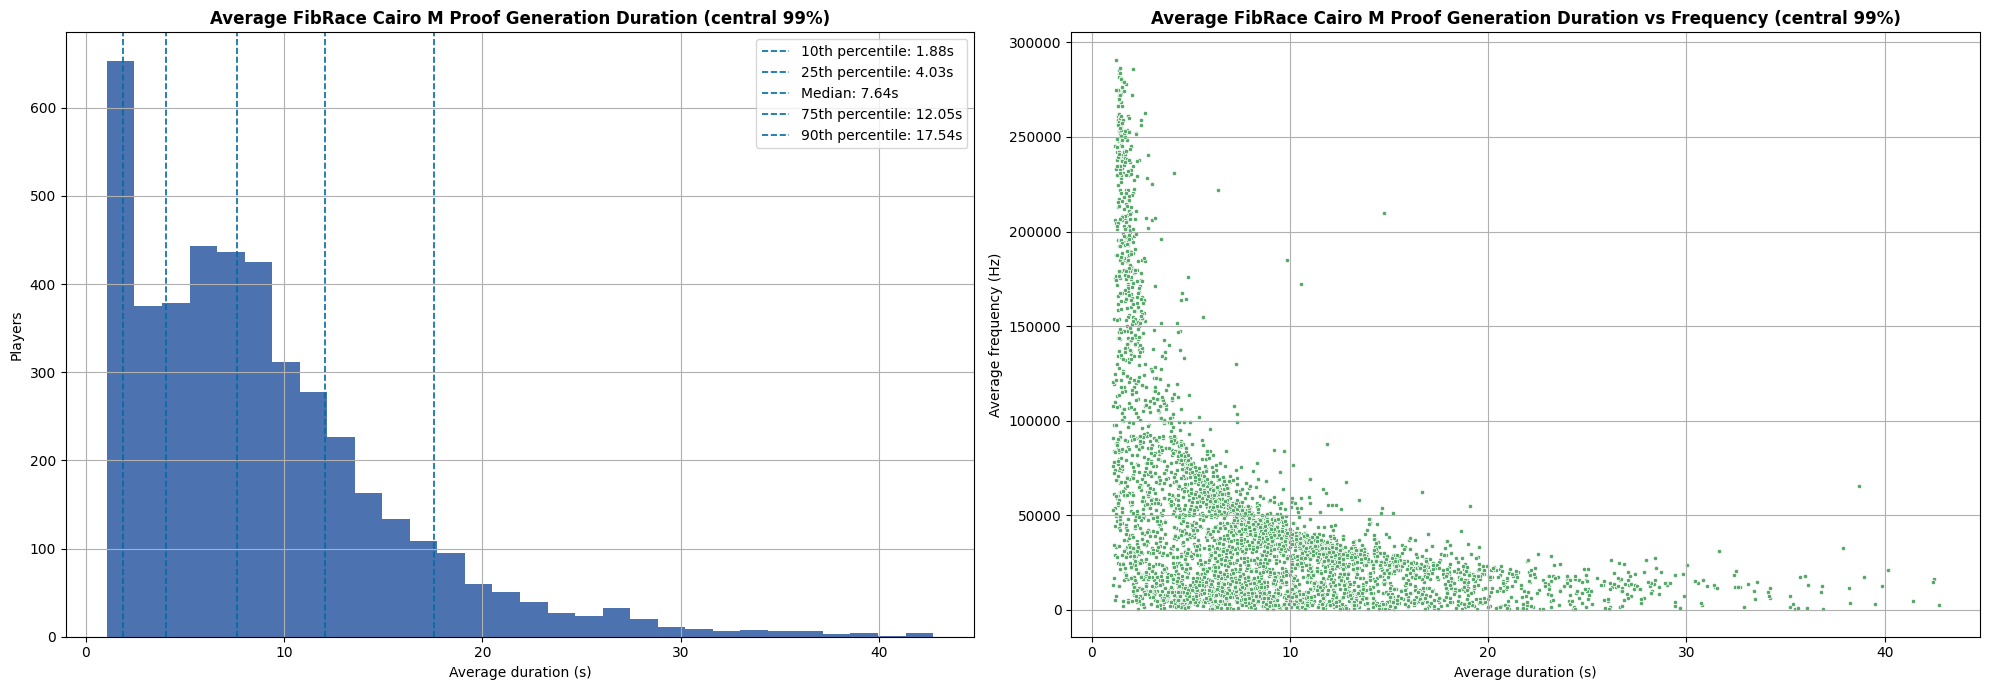

In [57]:
quantile_bounds = player_distribution_df.select([
    pl.col("avg_duration_s").quantile(0.005).alias("p005_duration"),
    pl.col("avg_duration_s").quantile(0.10).alias("p10_duration"),
    pl.col("avg_duration_s").quantile(0.25).alias("p25_duration"),
    pl.col("avg_duration_s").quantile(0.50).alias("p50_duration"),
    pl.col("avg_duration_s").quantile(0.75).alias("p75_duration"),
    pl.col("avg_duration_s").quantile(0.90).alias("p90_duration"),
    pl.col("avg_duration_s").quantile(0.995).alias("p995_duration"),
    pl.col("avg_frequency_hz").quantile(0.005).alias("p005_freq"),
    pl.col("avg_frequency_hz").quantile(0.995).alias("p995_freq"),
]).to_dict(as_series=False)

quantiles_duration = {
    "p005": quantile_bounds["p005_duration"][0],
    "p10": quantile_bounds["p10_duration"][0],
    "p25": quantile_bounds["p25_duration"][0],
    "p50": quantile_bounds["p50_duration"][0],
    "p75": quantile_bounds["p75_duration"][0],
    "p90": quantile_bounds["p90_duration"][0],
    "p995": quantile_bounds["p995_duration"][0],
}
duration_low = quantiles_duration["p005"]
duration_high = quantiles_duration["p995"]
freq_low, freq_high = quantile_bounds["p005_freq"][0], quantile_bounds["p995_freq"][0]

trimmed = player_distribution_df.filter(
    (pl.col("avg_duration_s") >= duration_low)
    & (pl.col("avg_duration_s") <= duration_high)
    & (pl.col("avg_frequency_hz") >= freq_low)
    & (pl.col("avg_frequency_hz") <= freq_high)
)
trim_durations = trimmed["avg_duration_s"].to_list()
trim_frequencies = trimmed["avg_frequency_hz"].to_list()
# trim_sizes = [20 + (count / 10 if count > 1000 else 0) for count in trimmed["proof_count"].to_list()]
trim_sizes = 10

fig, axes = plt.subplots(1, 2, figsize=(20, 7))

axes[0].hist(trim_durations, bins=30, color="#4C72B0")
axes[0].set_title("Average FibRace Cairo M Proof Generation Duration (central 99%)")
axes[0].set_xlabel("Average duration (s)")
axes[0].set_ylabel("Players")

quantile_lines = {
    "p10": (quantiles_duration["p10"], "10th percentile"),
    "p25": (quantiles_duration["p25"], "25th percentile"),
    "p50": (quantiles_duration["p50"], "Median"),
    "p75": (quantiles_duration["p75"], "75th percentile"),
    "p90": (quantiles_duration["p90"], "90th percentile"),
}

for key in ["p10", "p25", "p50", "p75", "p90"]:
    value, label = quantile_lines[key]
    axes[0].axvline(value, linestyle="--", linewidth=1.2, label=f"{label}: {value:.2f}s")

axes[0].legend(loc="upper right")

axes[1].scatter(
    trim_durations,
    trim_frequencies,
    s=trim_sizes,
    alpha=1,
    color="#55A868",
    edgecolor="white",
    linewidth=0.5,
)
axes[1].set_title("Average FibRace Cairo M Proof Generation Duration vs Frequency (central 99%)")
axes[1].set_xlabel("Average duration (s)")
axes[1].set_ylabel("Average frequency (Hz)")

plt.tight_layout()


## Device Specs and Proof Performance
Linking enriched device specs to proof performance highlights how hardware generation influences proving throughput.

### Manufacturer Summaries

Most of the FibRace proofs were generated on Xiaomi, Apple and Samsung devices. This is largely due to their market share and large offer of devices.

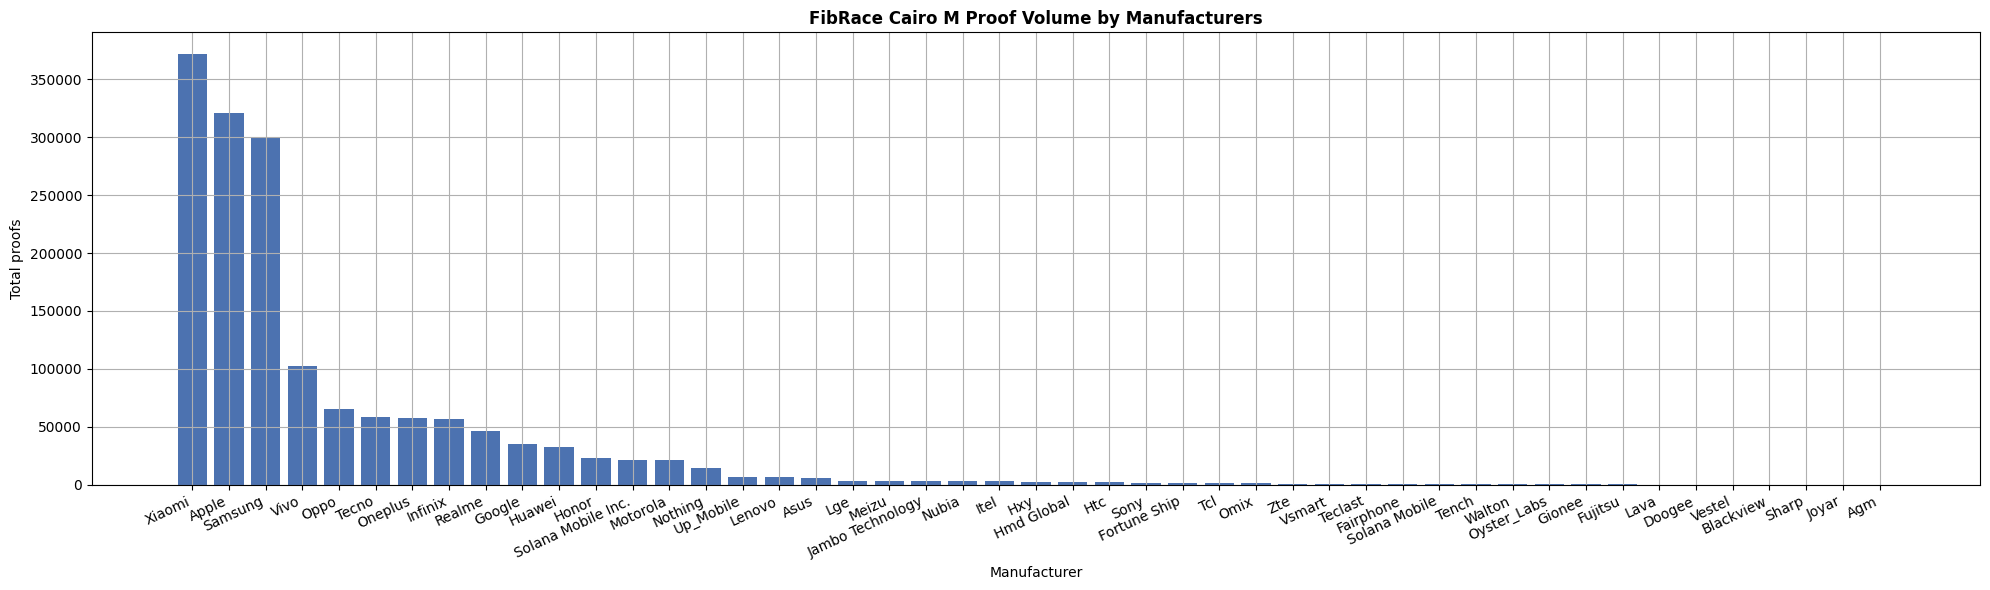

In [ ]:
manufacturer_summary = (
    player_perf_enriched
    .filter(pl.col("manufacturer").is_not_null())
    .group_by("manufacturer")
    .agg([
        pl.len().alias("players"),
        pl.col("proof_count").sum().alias("proofs"),
        pl.col("avg_duration_s").mean().alias("mean_avg_duration_s"),
        pl.col("avg_frequency_hz").mean().alias("mean_avg_frequency_hz"),
        pl.col("device_year_class").median().alias("median_device_year"),
    ])
    .sort("proofs", descending=True)
)

os_summary = (
    player_perf_enriched
    .filter(pl.col("os_name").is_not_null())
    .group_by("os_name")
    .agg([
        pl.len().alias("players"),
        pl.col("proof_count").sum().alias("proofs"),
        pl.col("avg_duration_s").mean().alias("mean_avg_duration_s"),
        pl.col("avg_frequency_hz").mean().alias("mean_avg_frequency_hz"),
    ])
    .sort("proofs", descending=True)
)

manufacturer_summary
os_summary

top_manufacturer_plot = manufacturer_summary.select(["manufacturer", "proofs"])
manufacturers = top_manufacturer_plot["manufacturer"].to_list()
proof_counts = top_manufacturer_plot["proofs"].to_list()

plt.figure(figsize=(20, 6))
plt.bar(manufacturers, proof_counts, color="#4C72B0")
plt.title("FibRace Cairo M Proof Volume by Manufacturers")
plt.xlabel("Manufacturer")
plt.ylabel("Total proofs")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()


### Device Top Dataset
Create datasets sorting the proof generation performance of the various benchmarked devices, sorted by best and average proving speed and frequency.

In [ ]:
model_aggregates = (
    player_perf_enriched
    .filter(pl.col("model_name").is_not_null())
    .group_by(["manufacturer", "model_name"])
    .agg([
        pl.len().alias("players"),
        pl.col("proof_count").sum().alias("proofs"),
        pl.col("avg_duration_s").mean().alias("mean_avg_duration_s"),
        pl.col("avg_frequency_hz").mean().alias("mean_avg_frequency_hz"),
        pl.col("best_duration_s").min().alias("best_duration_s"),
        pl.col("best_frequency_hz").max().alias("best_frequency_hz"),
        pl.col("marketing_name").drop_nulls().first().alias("marketing_name"),
    ])
)

marketing_counts = (
    model_aggregates
    .group_by("marketing_name")
    .agg(pl.len().alias("marketing_name_count"))
)

model_aggregates = (
    model_aggregates
    .join(marketing_counts, on="marketing_name", how="left")
    .with_columns([
        pl.when(
            pl.col("marketing_name").is_not_null()
            & (pl.col("marketing_name") != "")
            & (pl.col("marketing_name_count") == 1)
        )
        .then(pl.col("marketing_name"))
        .when(
            pl.col("marketing_name").is_not_null()
            & (pl.col("marketing_name") != "")
        )
        .then(
            pl.concat_str([
                pl.col("marketing_name"),
                pl.lit(" ("),
                pl.col("model_name"),
                pl.lit(")"),
            ])
        )
        .otherwise(
            pl.concat_str([
                pl.col("manufacturer"),
                pl.lit(" "),
                pl.col("model_name"),
            ])
        )
        .alias("display_label"),
    ])
)

top_models_by_proof = model_aggregates.sort("proofs", descending=True)
top_models_by_speed = model_aggregates.sort("mean_avg_duration_s")
top_models_by_frequency = model_aggregates.sort("mean_avg_frequency_hz", descending=True)
top_models_by_best_duration = (
    model_aggregates
    .filter(pl.col("best_duration_s").is_not_null())
    .sort("best_duration_s")
)
top_models_by_best_frequency = (
    model_aggregates
    .filter(pl.col("best_frequency_hz").is_not_null())
    .sort("best_frequency_hz", descending=True)
)


### Proving Metrics by Device
Aggregated view of how devices fare across proof generation frequency and duration.

The device brands that constitue the top 50 are Apple, Samsung, ZTE, OnePlus, Xiaomi, Oppo, Vivo and Google.
The best devices which generated Cairo M proofs in FibRace were iPads, mainly the latest generations of iPad Pro, with the Apple M4, Apple M2 and Apple M1 chips.
The iPhone 17 Pro, with an A19 Pro chip is close to the performance of the latest iPad Pro.
Best in class phones are not far away from iPad performances, with various iPhones models at the top of the ranking.

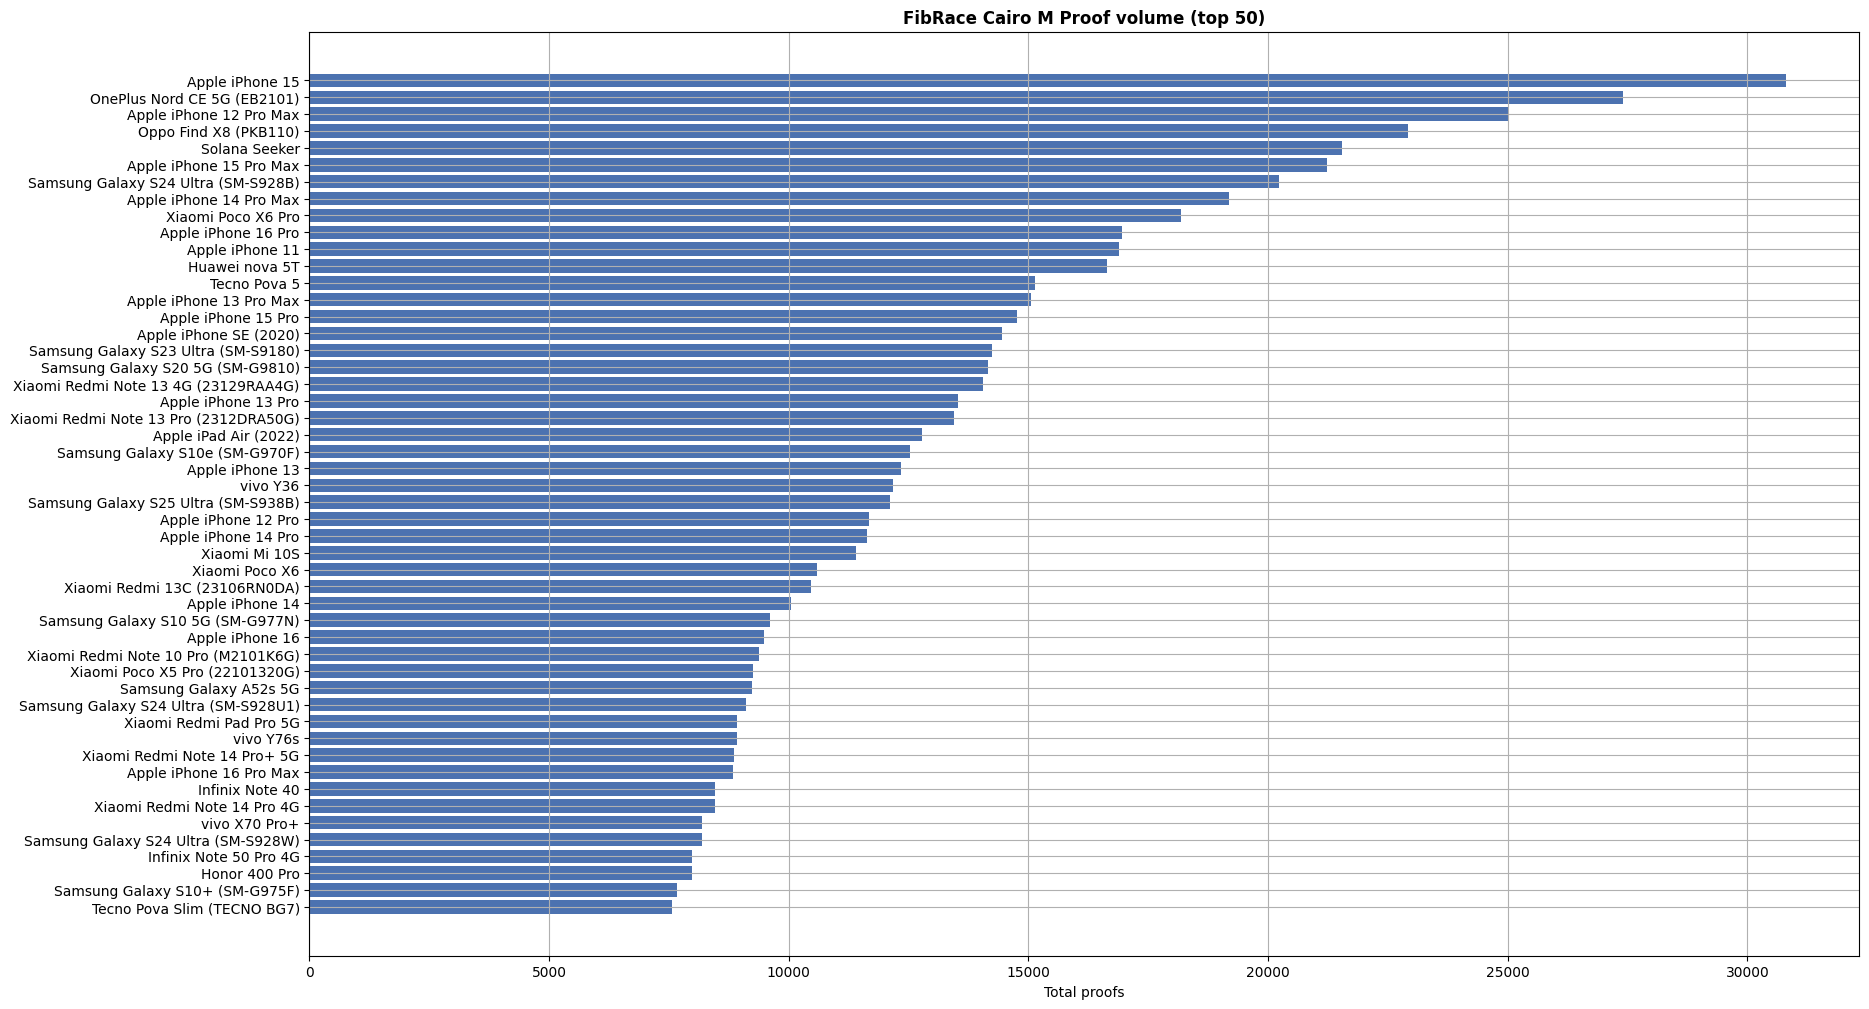

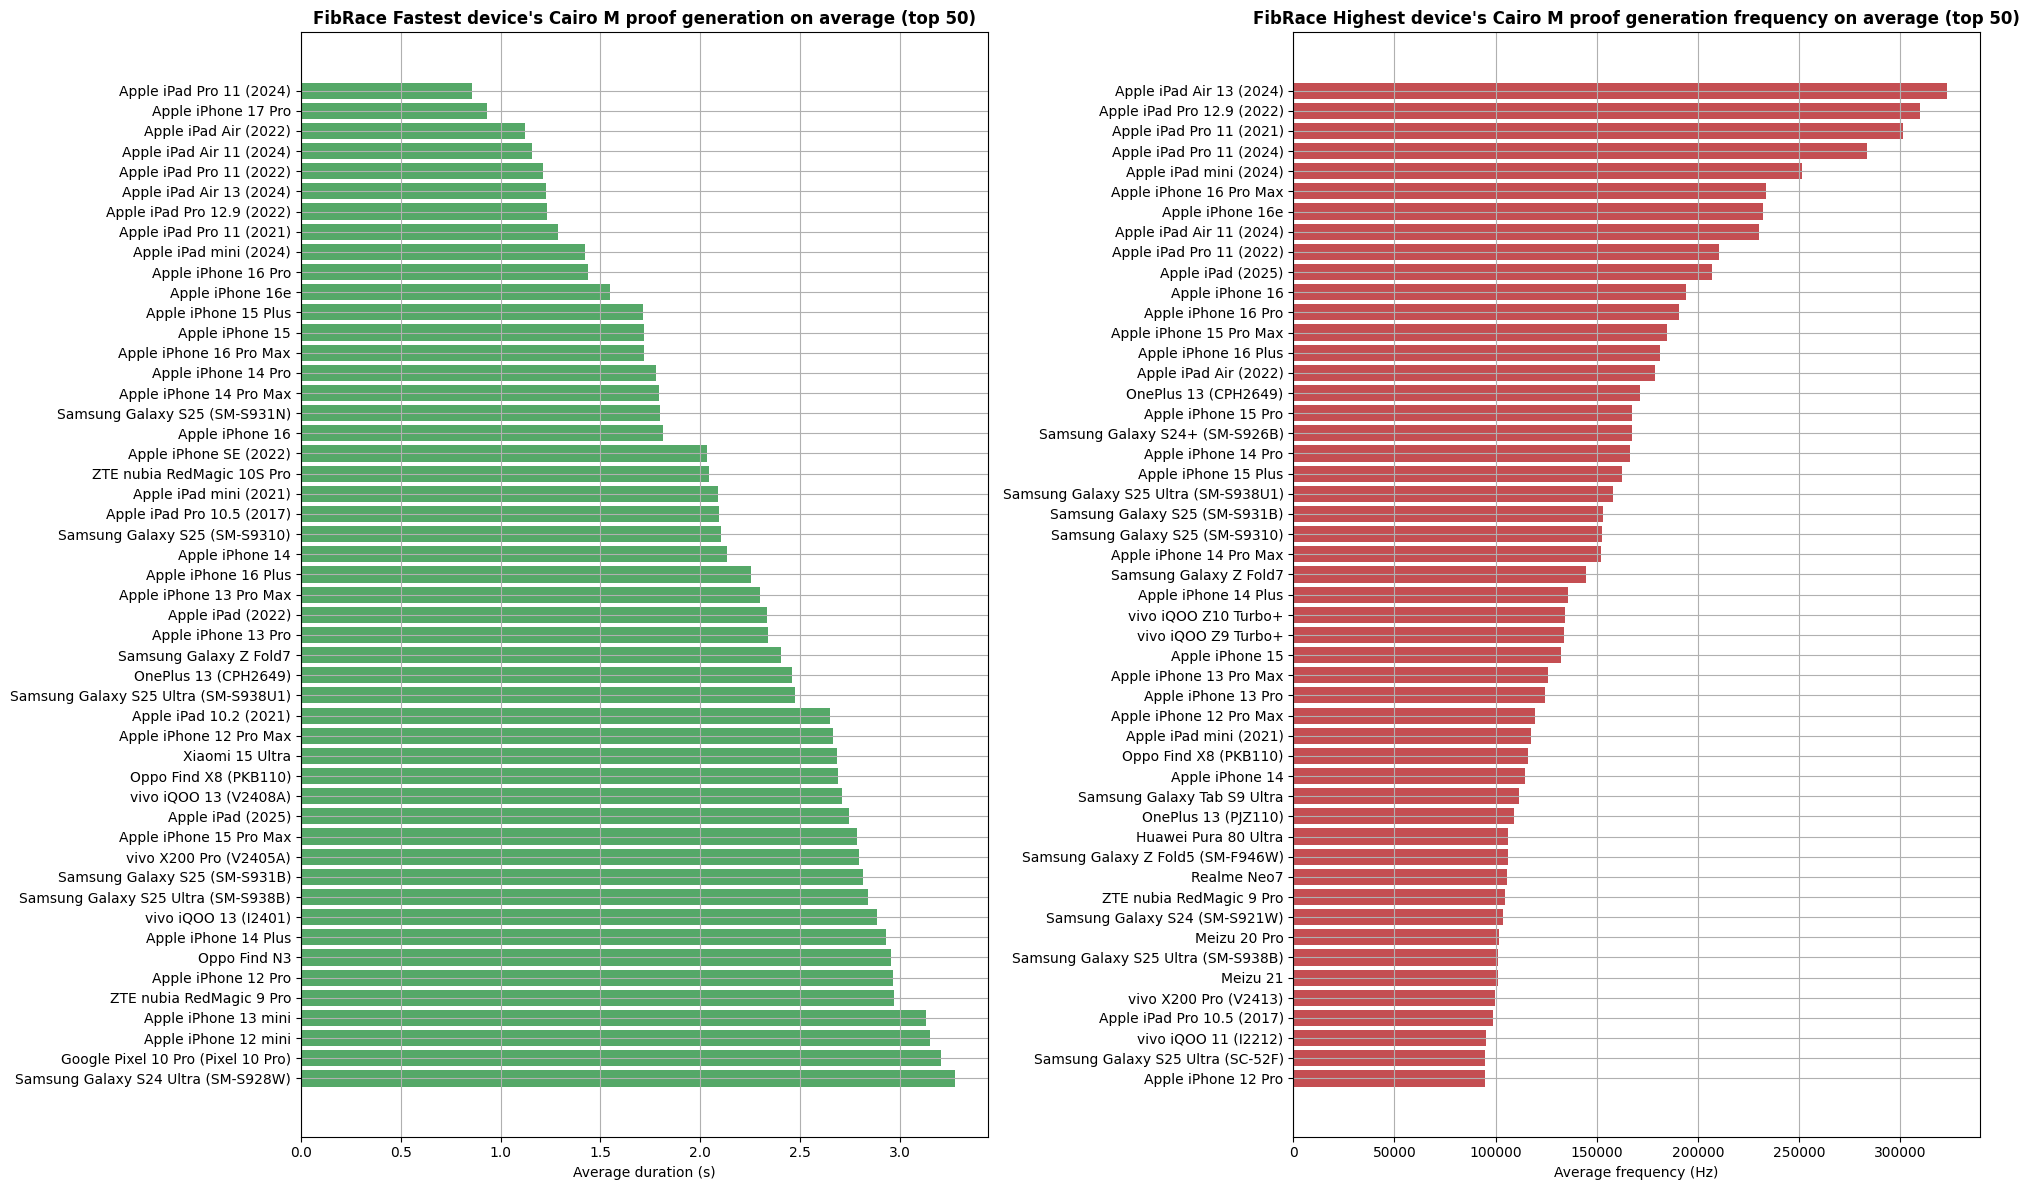

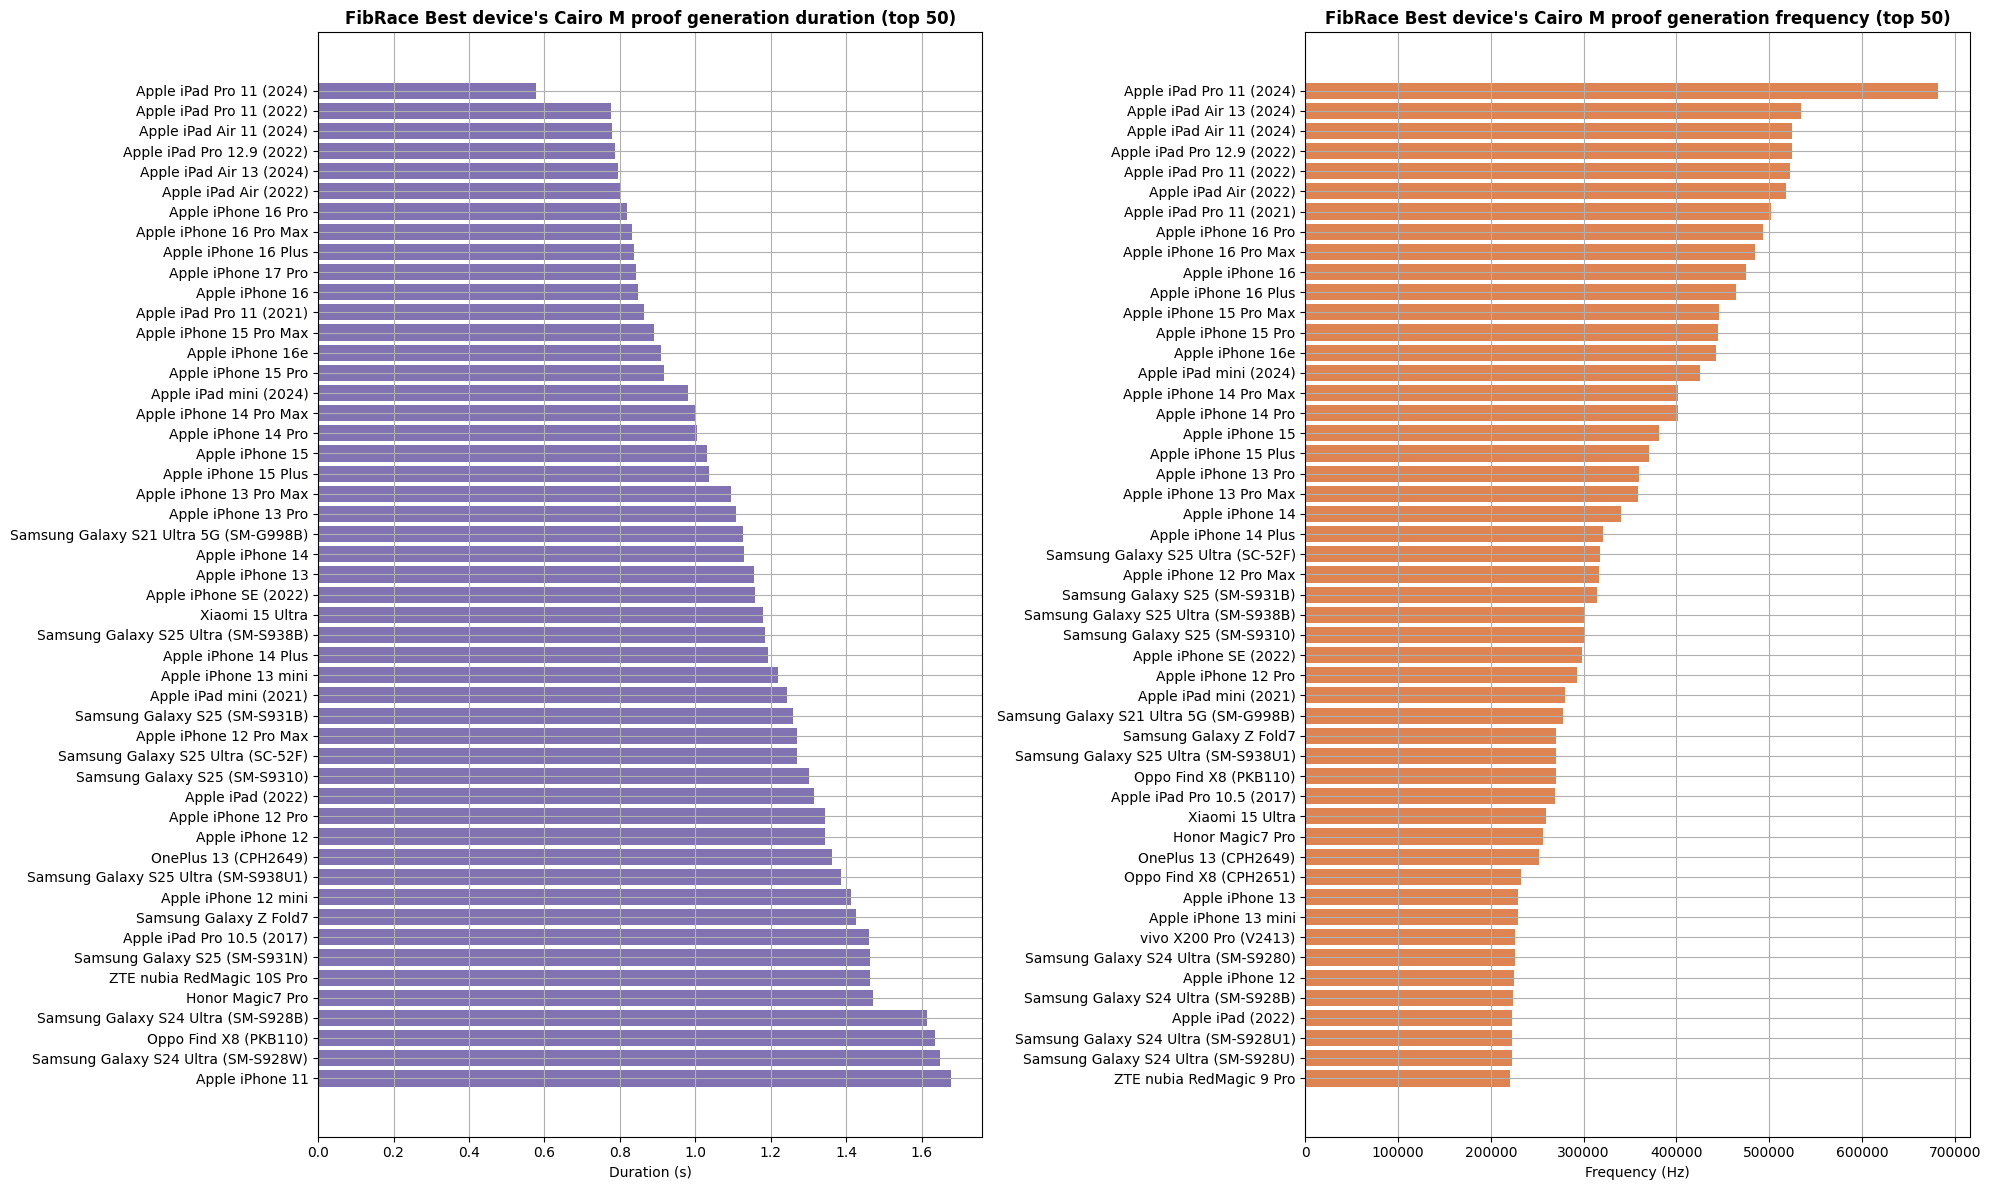

In [ ]:
def _barh(ax, df, value_col, title, xlabel, color, descending=False):
    subset = df.head(50)
    if subset.height == 0:
        ax.text(0.5, 0.5, "No data", ha="center", va="center")
        ax.set_axis_off()
        return

    ordered = subset.sort(value_col, descending=descending)

    labels = ordered.select(
        pl.when(
            pl.col("display_label").is_not_null()
            & (pl.col("display_label") != "")
        )
        .then(pl.col("display_label"))
        .otherwise(pl.col("model_name"))
        .alias("label")
    )["label"].to_list()

    values = ordered[value_col].to_list()
    ax.barh(labels, values, color=color)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.invert_yaxis()

fig0, axe = plt.subplots(1, figsize=(20, 12))
_barh(axe, top_models_by_proof, "proofs", "FibRace Cairo M Proof volume (top 50)", "Total proofs", "#4C72B0", True)

fig, axes = plt.subplots(1, 2, figsize=(20, 12))
volume_specs = [
    (top_models_by_speed, "mean_avg_duration_s", "FibRace Fastest device's Cairo M proof generation on average (top 50)", "Average duration (s)", "#55A868", False),
    (top_models_by_frequency, "mean_avg_frequency_hz", "FibRace Highest device's Cairo M proof generation frequency on average (top 50)", "Average frequency (Hz)", "#C44E52", True),
]
for ax, spec in zip(axes, volume_specs):
    _barh(ax, *spec)
plt.tight_layout()

fig, axes = plt.subplots(1, 2, figsize=(20, 12))
peak_specs = [
    (top_models_by_best_duration, "best_duration_s", "FibRace Best device's Cairo M proof generation duration (top 50)", "Duration (s)", "#8172B2", False),
    (top_models_by_best_frequency, "best_frequency_hz", "FibRace Best device's Cairo M proof generation frequency (top 50)", "Frequency (Hz)", "#DD8452", True),
]
for ax, spec in zip(axes, peak_specs):
    _barh(ax, *spec)
plt.tight_layout()

### Proving Metrics by SoC
Aggregated view of how SoC fare across proof generation frequency and duration.

Apple SoCs are scoring the top of the leaderboards, introducing a gap between its latest chipsets.
The Apple A19 Pro SoC, available in the iPhone 17 Pro competes with the Apple M1, M2 and M4 ones.
The best proving duration performance of the A19 Pro benchmarked are more than twice faster than the A18 Pro, the latter being on par with SoCs from other manufacturers (Mediatek, Qualcomm, Huawei and Samsung).

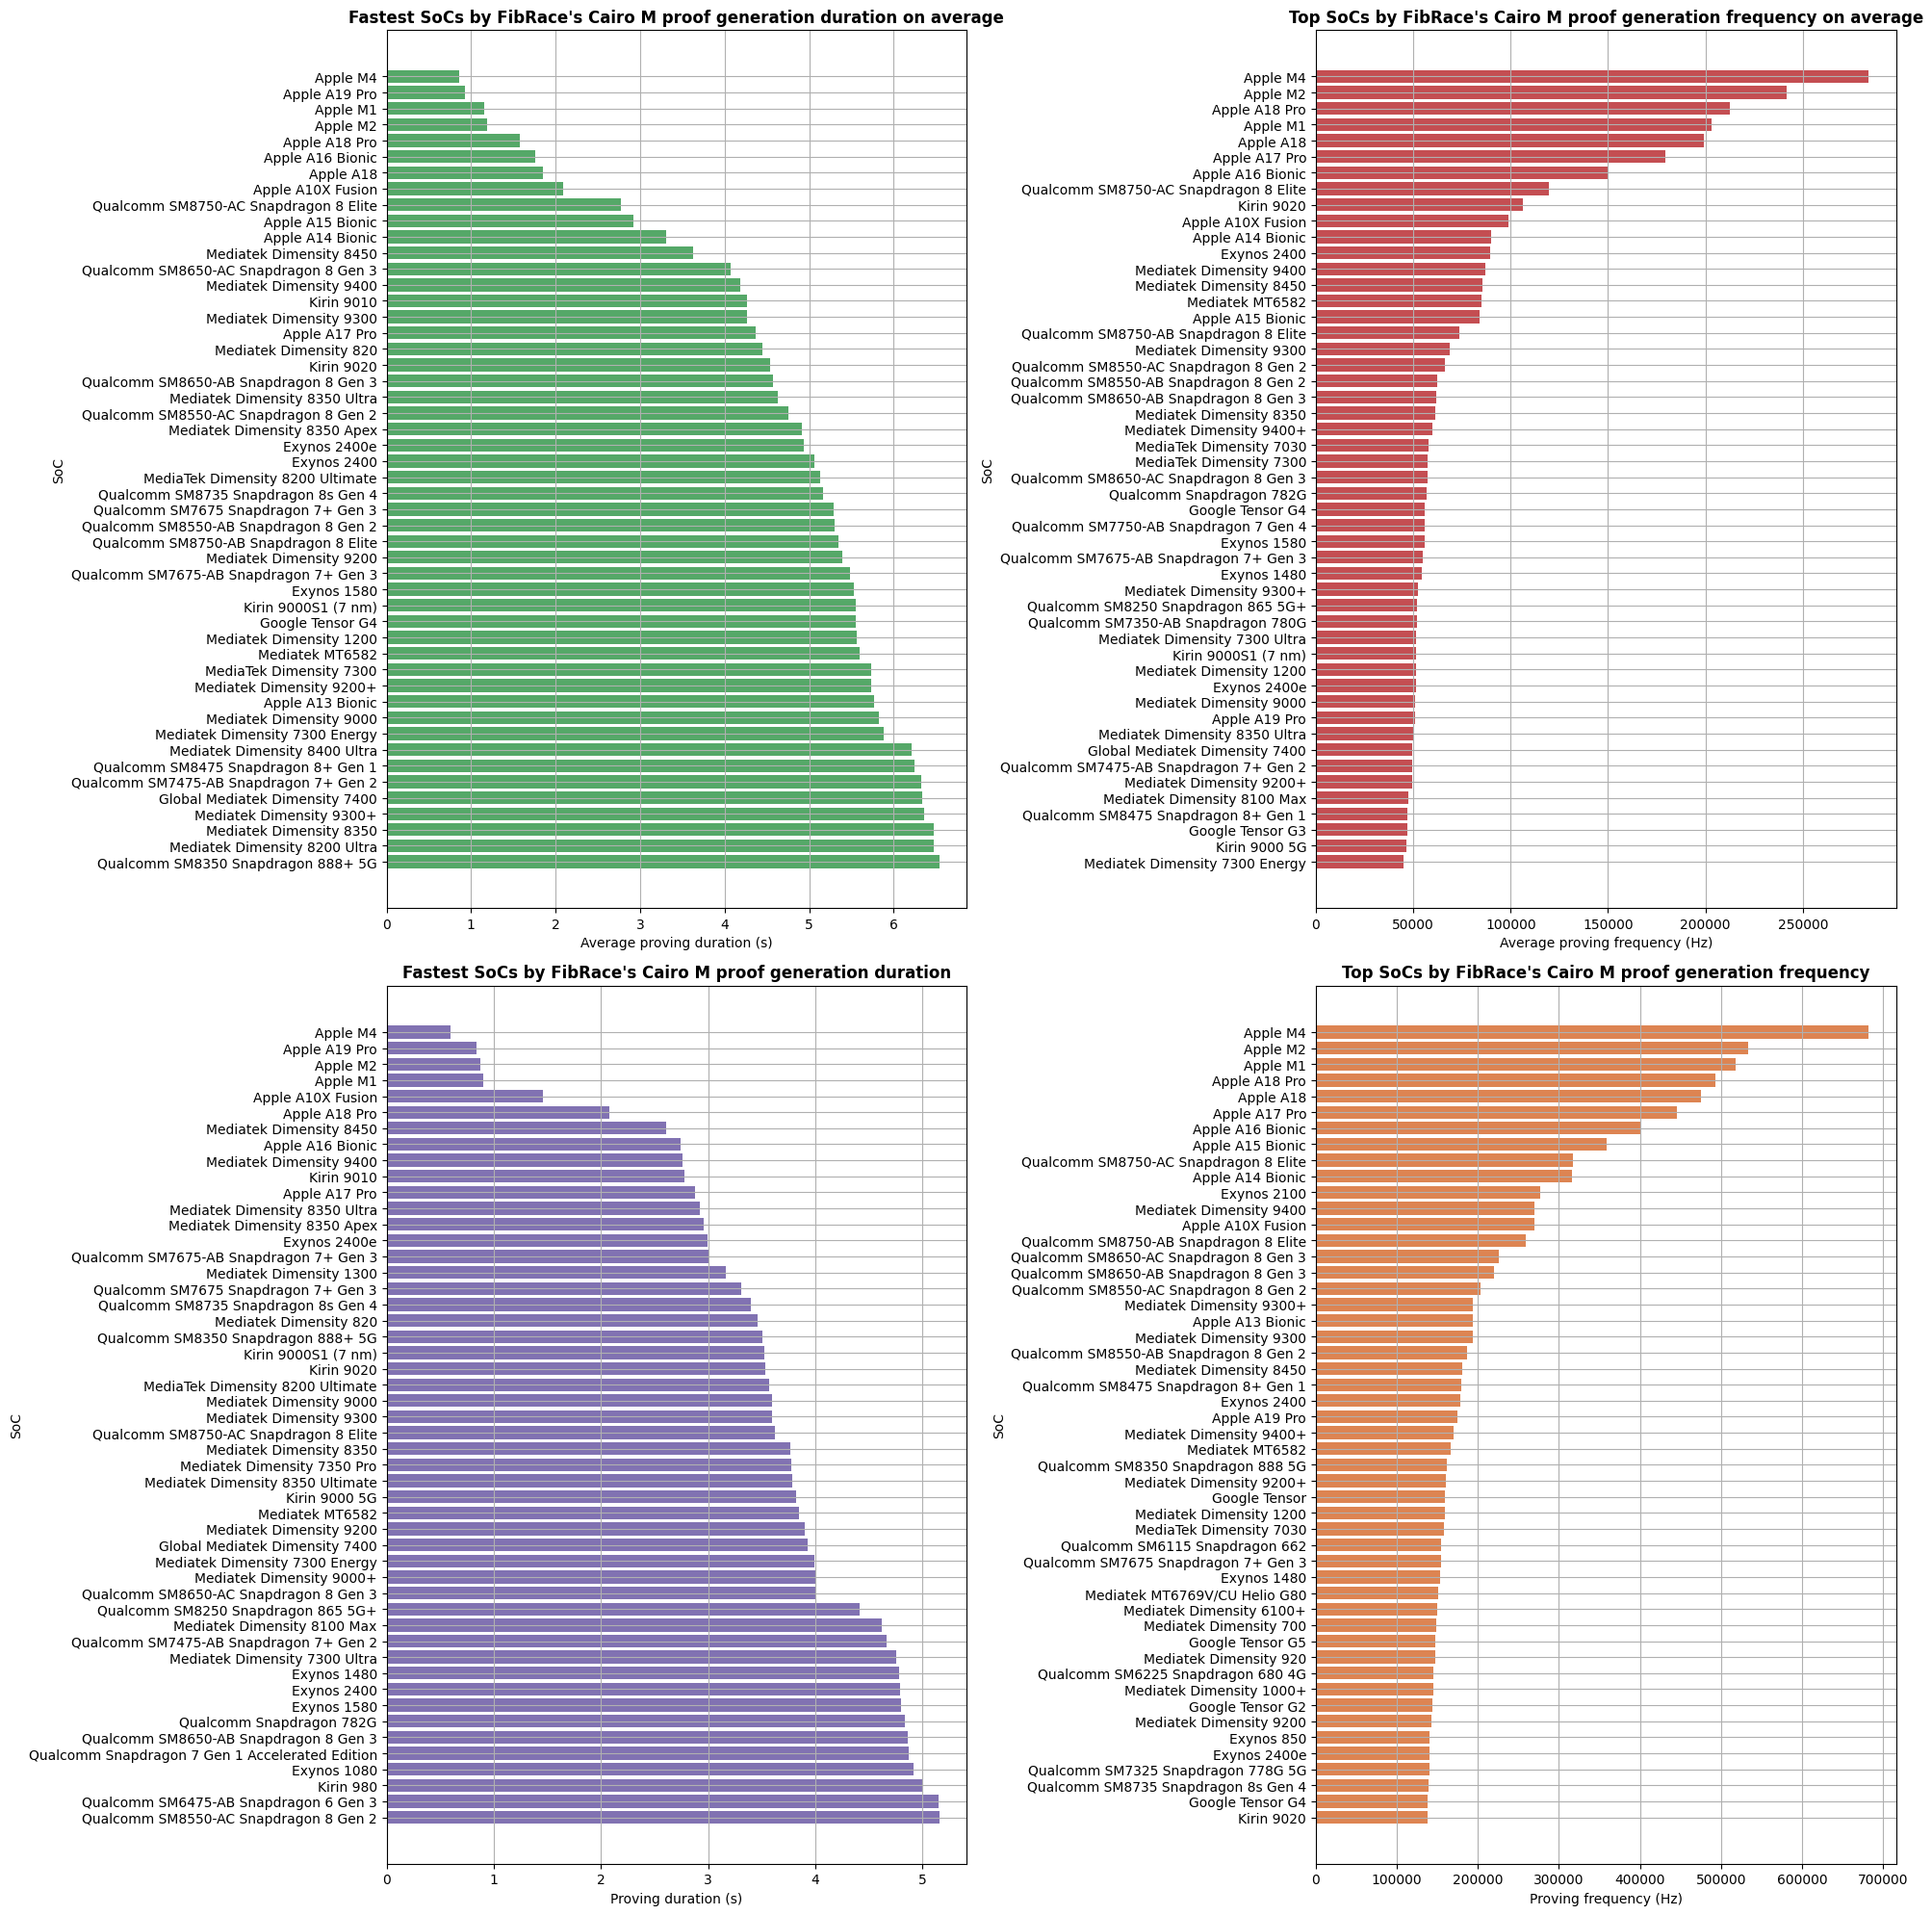

In [ ]:
soc_performance = (
    player_perf_enriched
    .filter(pl.col("soc").is_not_null())
    .filter(pl.col("soc") != "")
    .group_by("soc")
    .agg([
        pl.len().alias("players"),
        pl.col("avg_frequency_hz").mean().alias("mean_avg_frequency_hz"),
        pl.col("avg_duration_s").mean().alias("mean_avg_duration_s"),
        pl.col("best_frequency_hz").max().alias("soc_best_frequency_hz"),
        pl.col("best_duration_s").max().alias("soc_best_duration_s"),
    ])
)

if soc_performance.height == 0:
    print("Insufficient SoC-linked player data for aggregation.")
else:
    avg_freq_subset = (
        soc_performance
        .sort("mean_avg_frequency_hz", descending=True)
        .head(50)
        .reverse()
    )
    avg_duration_subset = (
        soc_performance
        .sort("mean_avg_duration_s")
        .head(50)
        .reverse()
    )
    best_freq_subset = (
        soc_performance.sort("soc_best_frequency_hz", descending=True).head(50).reverse()
    )
    best_duration_subset = (
        soc_performance.sort("soc_best_duration_s").head(50).reverse()
    )

    fig, axes = plt.subplots(2, 2, figsize=(20, 20))

    axes[0][0].barh(
        avg_duration_subset["soc"],
        avg_duration_subset["mean_avg_duration_s"],
        color="#55A868",
    )
    axes[0][0].set_title("Fastest SoCs by FibRace's Cairo M proof generation duration on average")
    axes[0][0].set_xlabel("Average proving duration (s)")
    axes[0][0].set_ylabel("SoC")

    axes[0][1].barh(
        avg_freq_subset["soc"],
        avg_freq_subset["mean_avg_frequency_hz"],
        color="#C44E52",
    )
    axes[0][1].set_title("Top SoCs by FibRace's Cairo M proof generation frequency on average")
    axes[0][1].set_xlabel("Average proving frequency (Hz)")
    axes[0][1].set_ylabel("SoC")

    axes[1][0].barh(
        best_duration_subset["soc"],
        best_duration_subset["soc_best_duration_s"],
        color="#8172B2",
    )
    axes[1][0].set_title("Fastest SoCs by FibRace's Cairo M proof generation duration")
    axes[1][0].set_xlabel("Proving duration (s)")
    axes[1][0].set_ylabel("SoC")

    axes[1][1].barh(
        best_freq_subset["soc"],
        best_freq_subset["soc_best_frequency_hz"],
        color="#DD8452",
    )
    axes[1][1].set_title("Top SoCs by FibRace's Cairo M proof generation frequency")
    axes[1][1].set_xlabel("Proving frequency (Hz)")
    axes[1][1].set_ylabel("SoC")

    plt.tight_layout()
    plt.show()


#### Proof Generation Performance Distribution over the SoC best core frequency

These panels shows the distribution of the proving duration and frequency over the core frequency of the device's chipset they are executed on.
We remark that the higher the core frequency is, the faster the proving is, while proving more (higher frequency on average).

For a given SoC's best core frequency, we still see notable variations between the devices, the architecture and manufacture of the overall chipset plays a significative roles which is not analyzed here (e.g.the other cores, as most recent CPUs are octa-core).

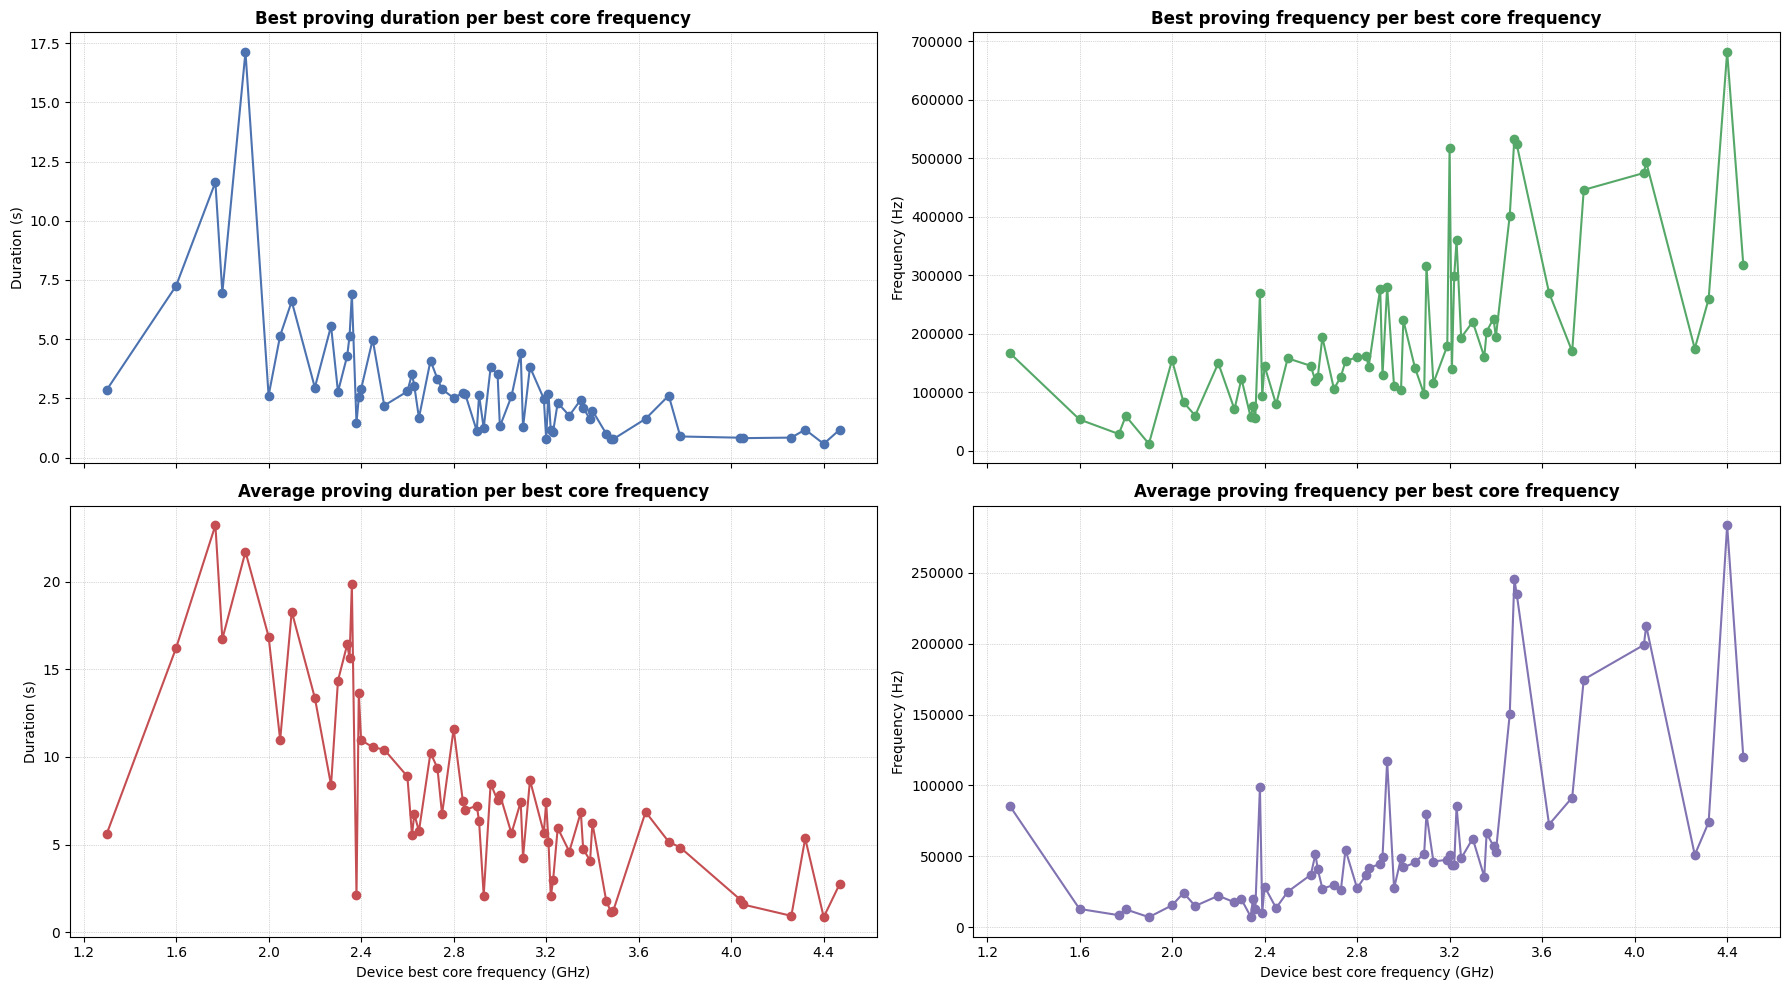

In [ ]:
import numpy as np
from matplotlib.ticker import MaxNLocator

player_with_core = (
    player_perf_enriched
    .filter(pl.col("best_core_freq_ghz").is_not_null())
    .filter(pl.col("best_core_freq_ghz") > 0)
    .with_columns(
        pl.col("best_core_freq_ghz")
        .round(2)
        .cast(pl.Float64)
        .alias("core_freq_ghz")
    )
    .filter(pl.col("core_freq_ghz").is_not_null())
)

if player_with_core.height == 0:
    print("No best core frequency data available for proving metrics.")
else:
    core_metrics = (
        player_with_core
        .group_by("core_freq_ghz")
        .agg([
            pl.col("best_duration_s")
            .filter(
                pl.col("best_duration_s").is_not_null()
                & (pl.col("best_duration_s") > 0)
            )
            .min()
            .alias("best_duration_s"),
            pl.col("best_frequency_hz")
            .filter(
                pl.col("best_frequency_hz").is_not_null()
                & (pl.col("best_frequency_hz") > 0)
            )
            .max()
            .alias("best_frequency_hz"),
            pl.col("avg_frequency_hz")
            .filter(
                pl.col("avg_frequency_hz").is_not_null()
                & (pl.col("avg_frequency_hz") > 0)
            )
            .mean()
            .alias("avg_frequency_hz"),
            pl.col("avg_duration_s")
            .filter(
                pl.col("avg_duration_s").is_not_null()
                & (pl.col("avg_duration_s") > 0)
            )
            .mean()
            .alias("avg_duration_s"),
            pl.len().alias("player_count"),
        ])
        .sort("core_freq_ghz")
    )

    if core_metrics.height == 0:
        print("No proving metrics available per core frequency.")
    else:
        core_labels = core_metrics["core_freq_ghz"].to_numpy()
        best_duration = np.array([
            float(value) if value is not None else np.nan
            for value in core_metrics["best_duration_s"].to_list()
        ], dtype=float)
        best_frequency = np.array([
            float(value) if value is not None else np.nan
            for value in core_metrics["best_frequency_hz"].to_list()
        ], dtype=float)
        avg_frequency = np.array([
            float(value) if value is not None else np.nan
            for value in core_metrics["avg_frequency_hz"].to_list()
        ], dtype=float)
        avg_duration = np.array([
            float(value) if value is not None else np.nan
            for value in core_metrics["avg_duration_s"].to_list()
        ], dtype=float)

        fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharex=True)
        axes = axes.ravel()

        axes[0].plot(
            core_labels,
            best_duration,
            marker="o",
            linestyle="-",
            color="#4C72B0",
            linewidth=1.5,
        )
        axes[0].set_title("Best proving duration per best core frequency")
        axes[0].set_ylabel("Duration (s)")
        axes[0].grid(True, axis="both", linestyle=":", linewidth=0.5)

        axes[1].plot(
            core_labels,
            best_frequency,
            marker="o",
            linestyle="-",
            color="#55A868",
            linewidth=1.5,
        )
        axes[1].set_title("Best proving frequency per best core frequency")
        axes[1].set_ylabel("Frequency (Hz)")
        axes[1].grid(True, axis="both", linestyle=":", linewidth=0.5)

        axes[2].plot(
            core_labels,
            avg_duration,
            marker="o",
            linestyle="-",
            color="#C44E52",
            linewidth=1.5,
        )
        axes[2].set_title("Average proving duration per best core frequency")
        axes[2].set_xlabel("Device best core frequency (GHz)")
        axes[2].set_ylabel("Duration (s)")
        axes[2].grid(True, axis="both", linestyle=":", linewidth=0.5)

        axes[3].plot(
            core_labels,
            avg_frequency,
            marker="o",
            linestyle="-",
            color="#8172B2",
            linewidth=1.5,
        )
        axes[3].set_title("Average proving frequency per best core frequency")
        axes[3].set_xlabel("Device best core frequency (GHz)")
        axes[3].set_ylabel("Frequency (Hz)")
        axes[3].grid(True, axis="both", linestyle=":", linewidth=0.5)

        for ax in axes:
            ax.xaxis.set_major_locator(MaxNLocator(nbins="auto"))

        plt.tight_layout()


#### CPU Core Frequency Timeline
Scatter of each device's fastest CPU core against its release date to show the CPU best core frequency of the device dataset.
The release date used is the one of the device, not the one of the CPU chipset.

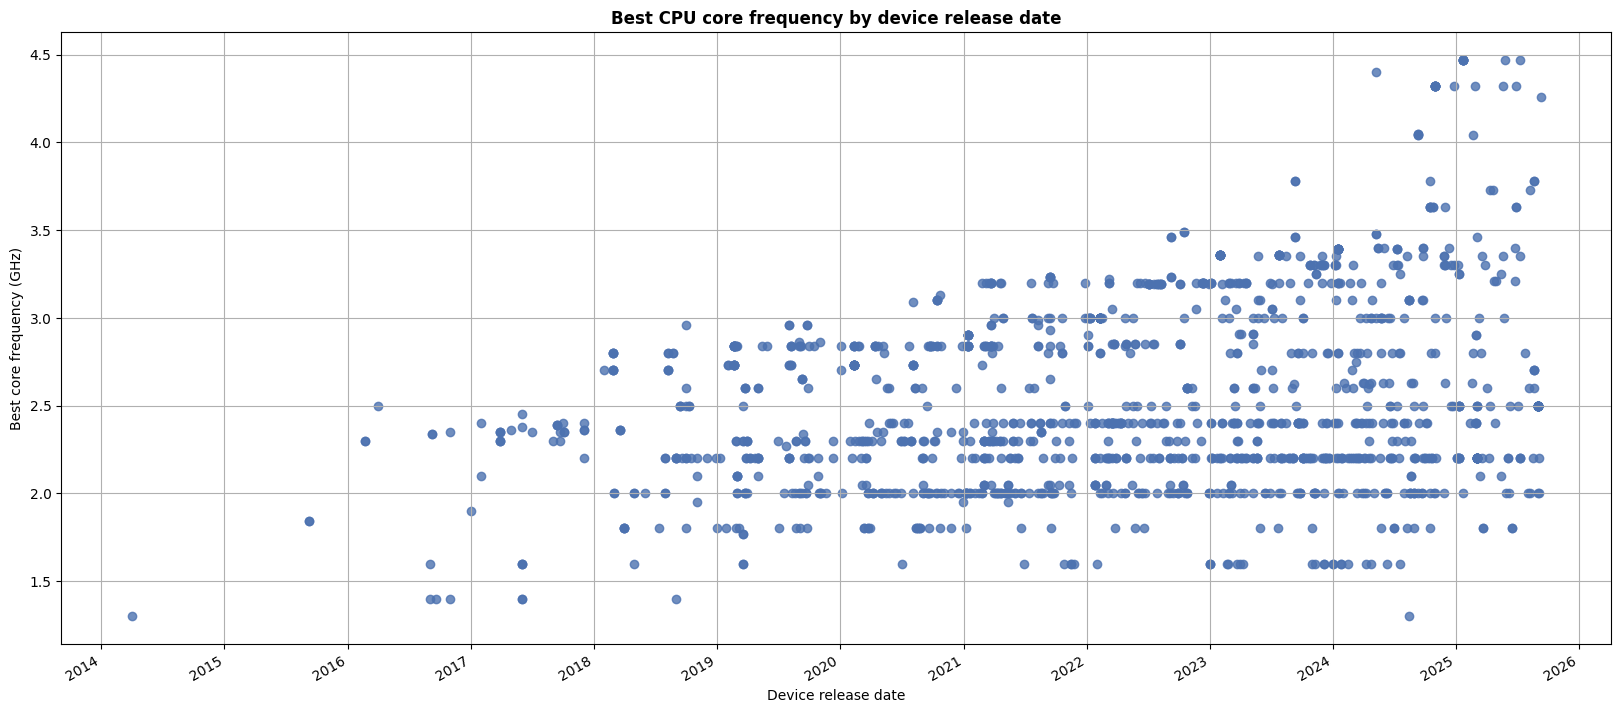

In [ ]:
device_core_timeline = (
    devices_lf
    .filter(
        pl.col("best_core_freq_ghz").is_not_null()
        & pl.col("release_date").is_not_null()
        & (pl.col("best_core_freq_ghz") > 0)
    )
    .group_by("model_name")
    .agg([
        pl.col("release_date").min().alias("release_date"),
        pl.col("marketing_name").drop_nulls().first().alias("marketing_name"),
        pl.col("soc").drop_nulls().first().alias("soc"),
        pl.col("best_core_freq_ghz").max().alias("best_core_freq_ghz"),
    ])
    .with_columns([
        pl.when(pl.col("marketing_name").is_null() | (pl.col("marketing_name") == ""))
        .then(pl.col("model_name"))
        .otherwise(pl.col("marketing_name"))
        .alias("device_label"),
    ])
    .sort("release_date")
    .collect()
)

if device_core_timeline.height == 0:
    print("No enriched device release data available.")
else:
    release_dates = device_core_timeline["release_date"].to_numpy()
    core_freq = device_core_timeline["best_core_freq_ghz"].to_numpy()

    fig, ax = plt.subplots(figsize=(20, 9))
    ax.scatter(
        release_dates,
        core_freq,
        alpha=0.8,
        c="#4C72B0",
    )
    ax.set_title("Best CPU core frequency by device release date")
    ax.set_xlabel("Device release date")
    ax.set_ylabel("Best core frequency (GHz)")
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    fig.autofmt_xdate()

    plt.show()


#### Player & Device proving duration over release date

Panel A shows each player's best proof generation duration distributed across their device's release date ; Multiple players could have the same device: Panel B rolls that up to the top-performing player for the given device.

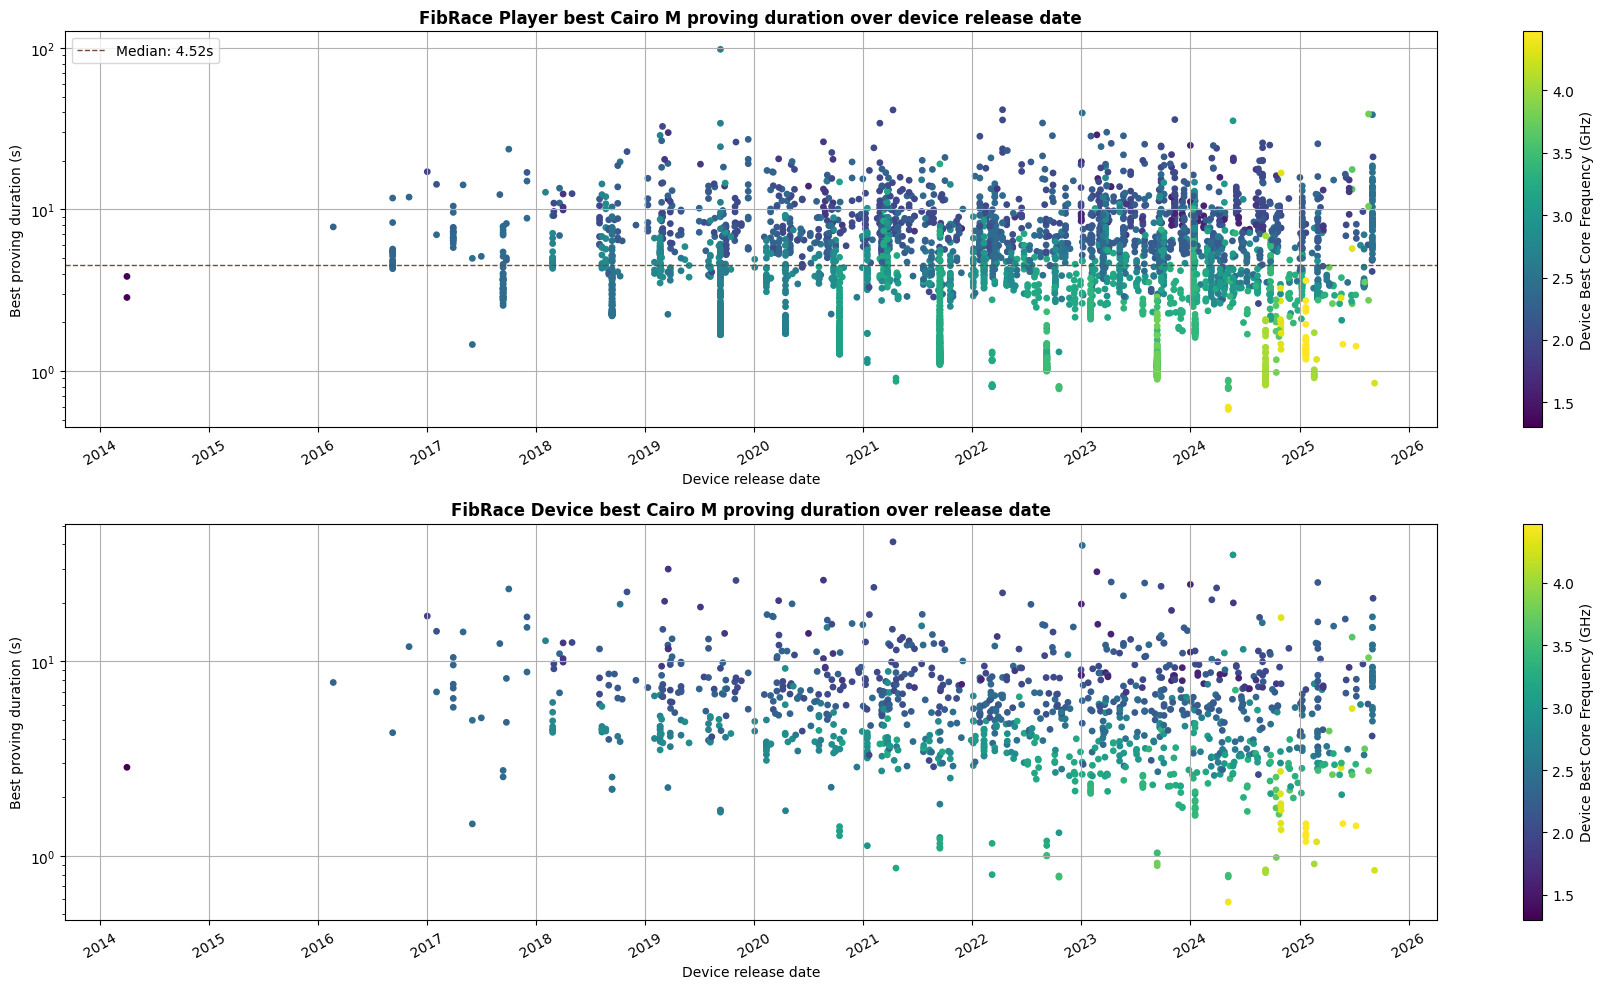

In [ ]:
player_best_duration = (
    player_perf_enriched
    .filter(pl.col("release_date").is_not_null())
    .filter(pl.col("best_duration_s").is_not_null())
    .filter(pl.col("best_duration_s") > 0)
    .select([
        "playerId",
        "model_name",
        "release_date",
        "best_duration_s",
        "avg_duration_s",
        "proof_count",
        "marketing_name",
        "soc",
        "best_core_freq_ghz",
    ])
)

if player_best_duration.height == 0:
    print("No player proving duration data with device release dates.")
else:
    release_dates = player_best_duration["release_date"].to_numpy()
    best_duration = player_best_duration["best_duration_s"].to_numpy()
    avg_duration = player_best_duration["avg_duration_s"].to_numpy()
    best_core_freq = player_best_duration["best_core_freq_ghz"].to_numpy()
    proof_counts = player_best_duration["proof_count"].to_numpy()

    fig, axes = plt.subplots(2, 1, figsize=(18, 10))

    scatter_players = axes[0].scatter(
        release_dates,
        best_duration,
        c=best_core_freq,
        cmap="viridis",
        alpha=1,
        s=15
    )
    axes[0].set_title("FibRace Player best Cairo M proving duration over device release date")
    axes[0].set_xlabel("Device release date")
    axes[0].set_ylabel("Best proving duration (s)")
    axes[0].set_yscale("log")
    axes[0].xaxis.set_major_locator(mdates.YearLocator(base=1))
    axes[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    axes[0].tick_params(axis="x", rotation=30)
    median_value = float(pl.Series(best_duration).median())
    axes[0].axhline(
        median_value,
        color="#6F4E37",
        linestyle="--",
        linewidth=1,
        label=f"Median: {median_value:.2f}s",
    )
    axes[0].legend(loc="upper left")

    cbar_players = plt.colorbar(scatter_players, ax=axes[0])
    cbar_players.set_label("Device Best Core Frequency (GHz)")

    device_best_duration = (
        player_best_duration
        .filter(pl.col("model_name").is_not_null())
        .group_by("model_name")
        .agg([
            pl.col("release_date").drop_nulls().min().alias("release_date"),
            pl.col("marketing_name").drop_nulls().first().alias("marketing_name"),
            pl.col("best_duration_s").min().alias("best_duration_s"),
            pl.col("best_core_freq_ghz").max().alias("best_core_freq_ghz"),
            pl.len().alias("player_count"),
        ])
        .filter(pl.col("release_date").is_not_null())
        .sort("release_date")
    )

    if device_best_duration.height == 0:
        axes[1].text(0.5, 0.5, "No device-level data", ha="center", va="center")
        axes[1].set_axis_off()
    else:
        device_release = device_best_duration["release_date"].to_numpy()
        device_best = device_best_duration["best_duration_s"].to_numpy()
        device_players = device_best_duration["player_count"].to_numpy()
        device_best_core_freq = device_best_duration["best_core_freq_ghz"].to_numpy()
        sizes_device = 15

        scatter_devices = axes[1].scatter(
            device_release,
            device_best,
            c=device_best_core_freq,
            cmap="viridis",
            alpha=1,
            s=sizes_device,
        )
        axes[1].set_title("FibRace Device best Cairo M proving duration over release date")
        axes[1].set_xlabel("Device release date")
        axes[1].set_ylabel("Best proving duration (s)")
        axes[1].set_yscale("log")
        axes[1].xaxis.set_major_locator(mdates.YearLocator(base=1))
        axes[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
        axes[1].tick_params(axis="x", rotation=30)

        cbar_devices = plt.colorbar(scatter_devices, ax=axes[1])
        cbar_devices.set_label("Device Best Core Frequency (GHz)")

    plt.tight_layout()
    plt.show()


#### Player & Device proving frequency over release date
Panels mirror the duration view, but focus on highest frequency proofs: fastest while wheighting the computational workload.

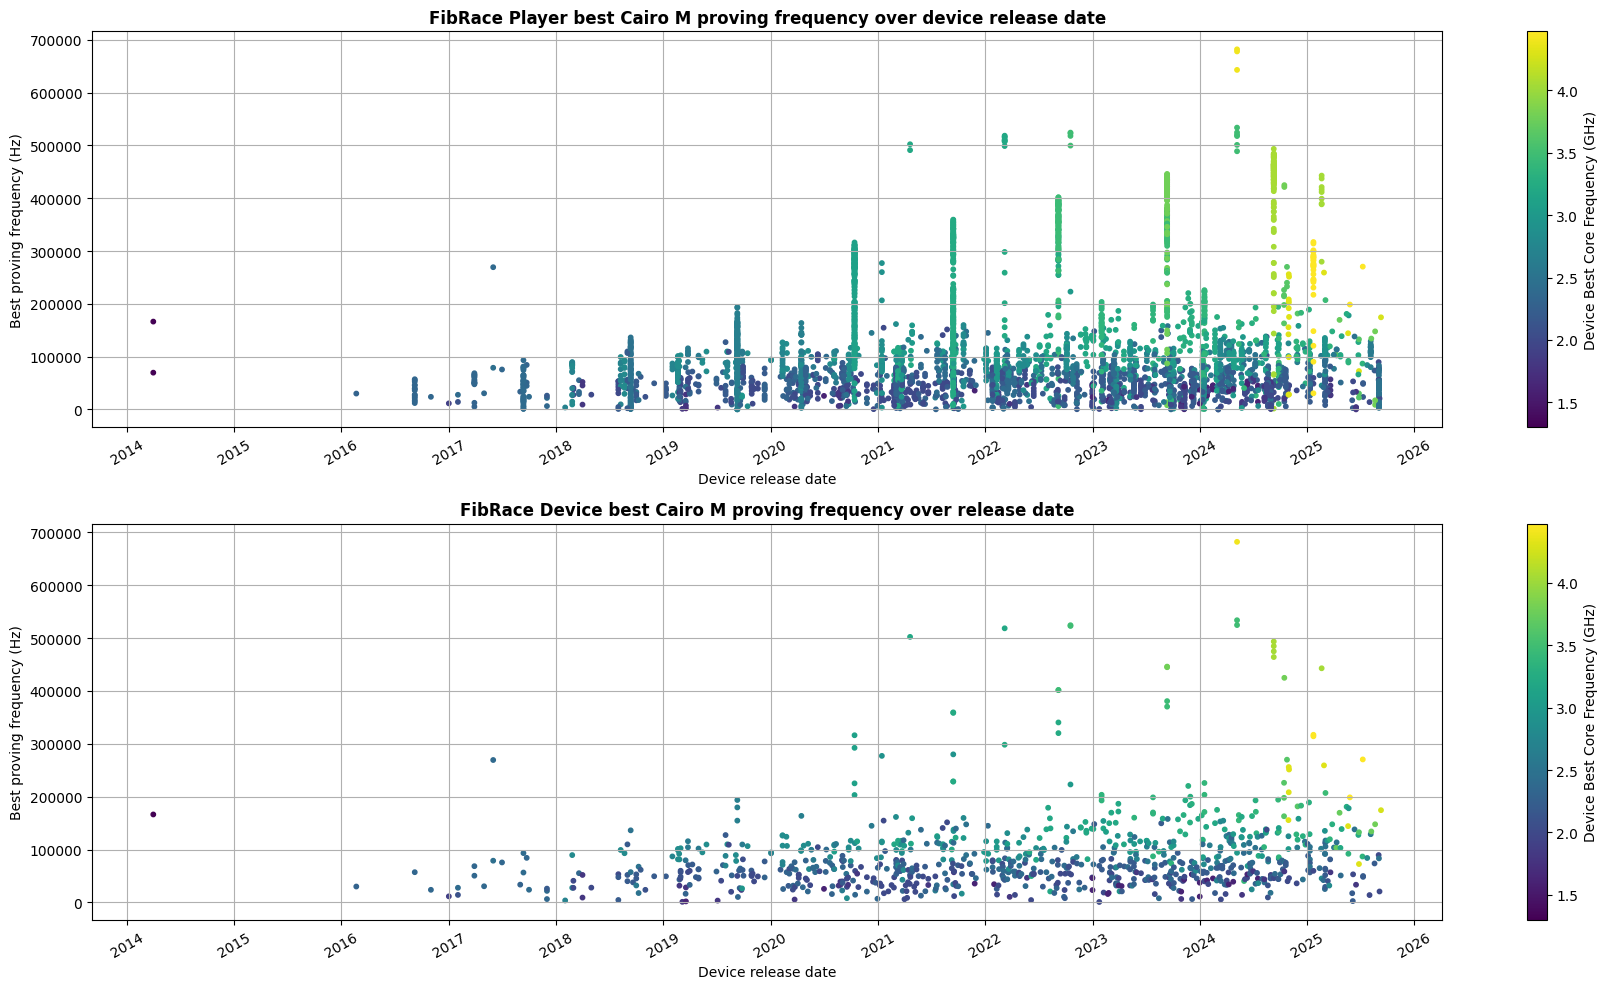

In [ ]:
player_best_frequency = (
    player_perf_enriched
    .filter(pl.col("release_date").is_not_null())
    .filter(pl.col("best_frequency_hz").is_not_null())
    .select([
        "playerId",
        "model_name",
        "release_date",
        "best_frequency_hz",
        "avg_frequency_hz",
        "proof_count",
        "marketing_name",
        "soc",
        "best_core_freq_ghz",
    ])
)

if player_best_frequency.height == 0:
    print("No player proving frequency data with device release dates.")
else:
    release_dates = player_best_frequency["release_date"].to_numpy()
    best_freq = player_best_frequency["best_frequency_hz"].to_numpy()
    avg_freq = player_best_frequency["avg_frequency_hz"].to_numpy()
    player_core_freq = player_best_frequency["best_core_freq_ghz"].to_numpy()
    proof_counts = player_best_frequency["proof_count"].to_numpy()

    fig, axes = plt.subplots(2, 1, figsize=(18, 10))

    scatter_players = axes[0].scatter(
        release_dates,
        best_freq,
        c=player_core_freq,
        cmap="viridis",
        alpha=1,
        s=10
    )
    axes[0].set_title("FibRace Player best Cairo M proving frequency over device release date")
    axes[0].set_xlabel("Device release date")
    axes[0].set_ylabel("Best proving frequency (Hz)")
    axes[0].xaxis.set_major_locator(mdates.YearLocator(base=1))
    axes[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    axes[0].tick_params(axis="x", rotation=30)

    cbar_players = plt.colorbar(scatter_players, ax=axes[0])
    cbar_players.set_label("Device Best Core Frequency (GHz)")

    device_best_frequency = (
        player_best_frequency
        .filter(pl.col("model_name").is_not_null())
        .group_by("marketing_name")
        .agg([
            pl.col("release_date").drop_nulls().min().alias("release_date"),
            pl.col("best_frequency_hz").max().alias("best_frequency_hz"),
            pl.col("best_core_freq_ghz").max().alias("best_core_freq_ghz"),
            pl.len().alias("player_count"),
        ])
        .filter(pl.col("release_date").is_not_null())
        .sort("release_date")
    )

    if device_best_frequency.height == 0:
        axes[1].text(0.5, 0.5, "No device-level data", ha="center", va="center")
        axes[1].set_axis_off()
    else:
        device_release = device_best_frequency["release_date"].to_numpy()
        device_best = device_best_frequency["best_frequency_hz"].to_numpy()
        device_players = device_best_frequency["player_count"].to_numpy()
        device_core_freq = device_best_frequency["best_core_freq_ghz"].to_numpy()
        sizes_device = 10

        scatter_devices = axes[1].scatter(
            device_release,
            device_best,
            c=device_core_freq,
            cmap="viridis",
            alpha=1,
            s=sizes_device,
        )
        axes[1].set_title("FibRace Device best Cairo M proving frequency over release date")
        axes[1].set_xlabel("Device release date")
        axes[1].set_ylabel("Best proving frequency (Hz)")
        axes[1].xaxis.set_major_locator(mdates.YearLocator(base=1))
        axes[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
        axes[1].tick_params(axis="x", rotation=30)

        cbar_devices = plt.colorbar(scatter_devices, ax=axes[1])
        cbar_devices.set_label("Device Best Core Frequency (GHz)")

    plt.tight_layout()
    plt.show()


### Proving Metrics by RAM
Aggregated view of how RAM fare across proof generation frequency and duration.

#### Distribution of Proof Generation Duration and Frequency per RAM capacity

The first panel shows the complete distributions of the FibRace proofs duration and frequency per RAM capacity.
The second panel shows the distribution of a trimmed view 0-95% of the proofs of each RAM capacity, to remove the few extreme outliers (worst duration, best frequencies), and better visualize the main frame.

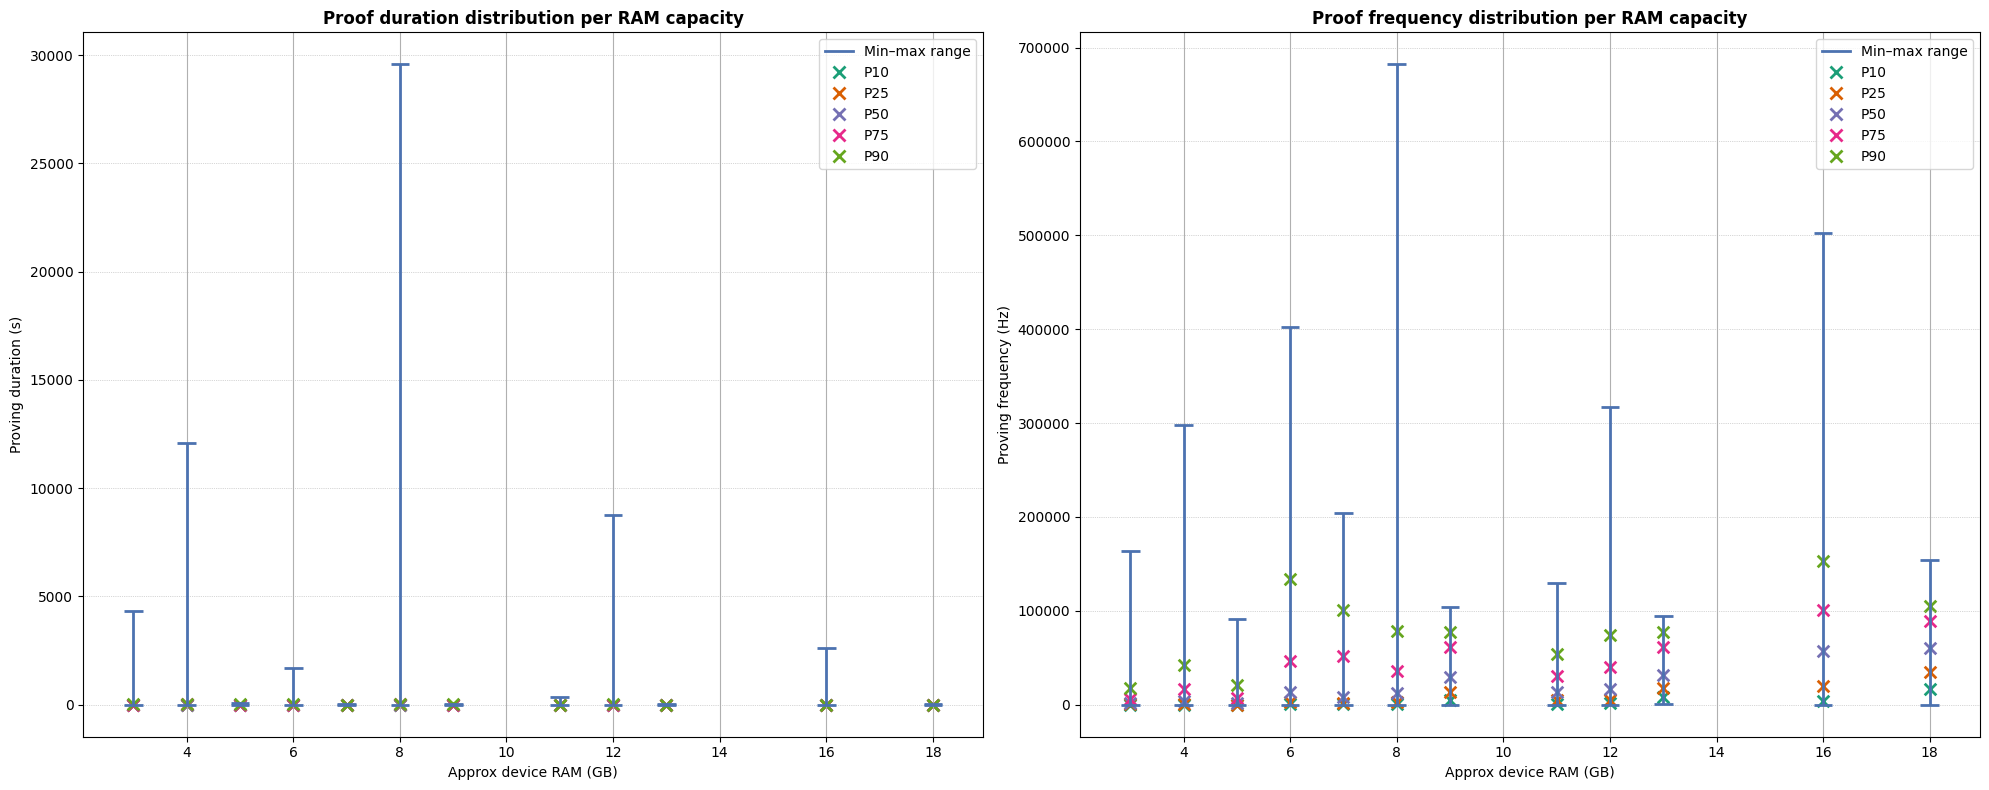

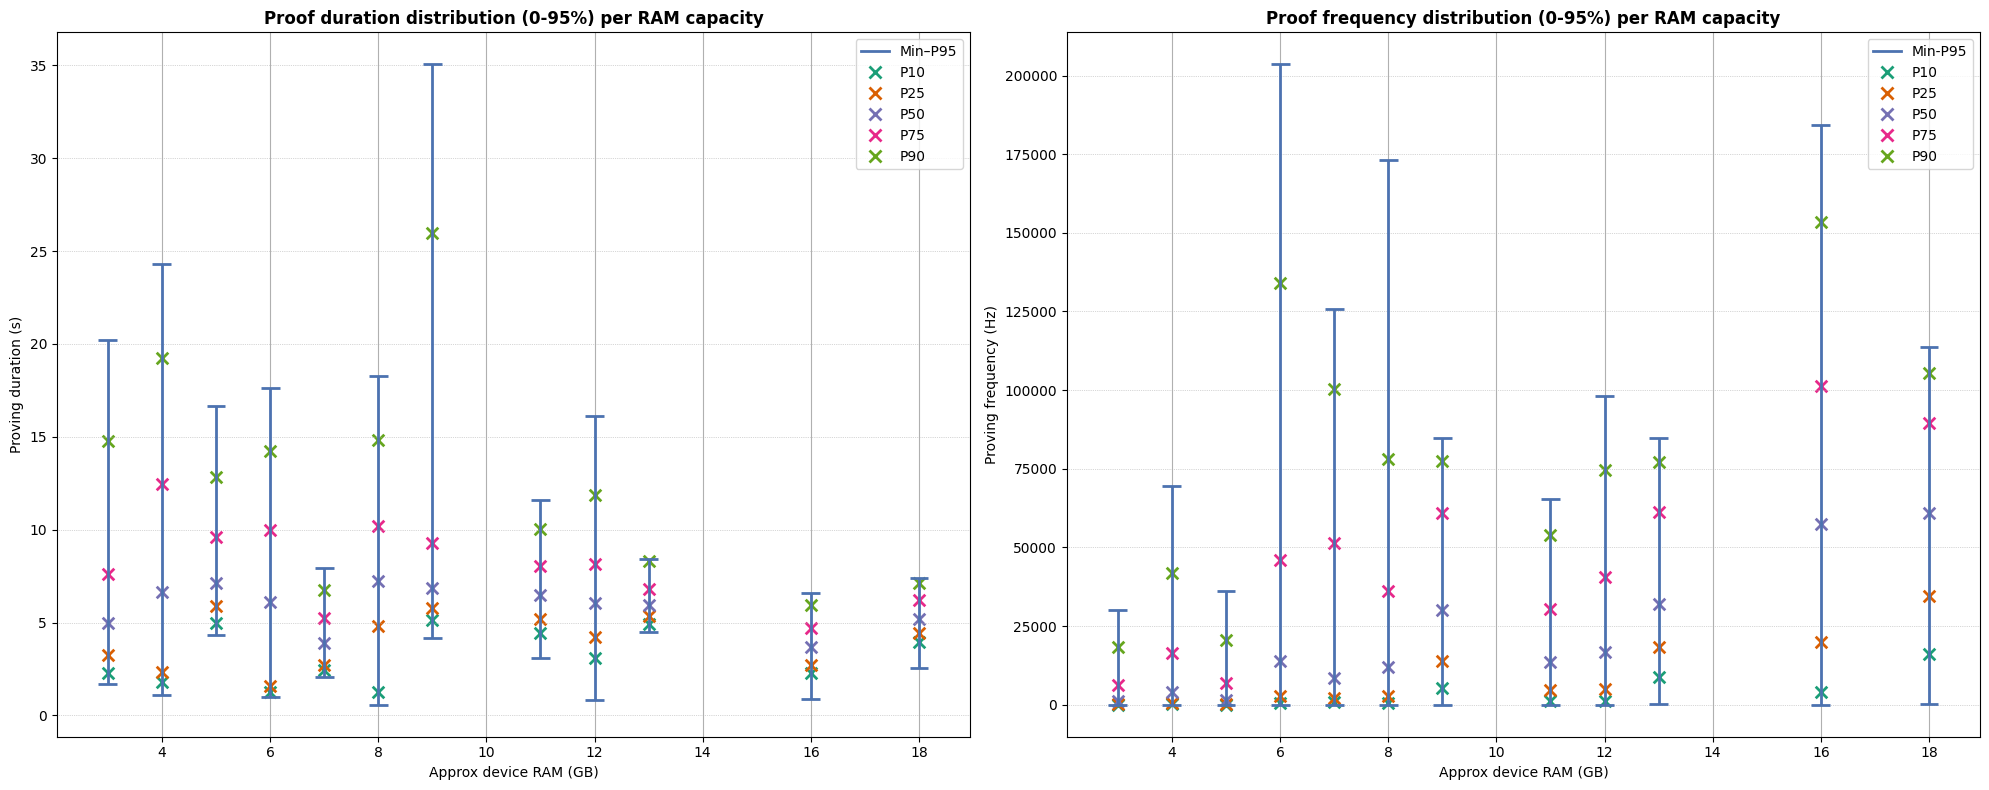

In [ ]:
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator

ram_bucket_expr = (
    pl.when(
        pl.col("total_memory_bytes").is_not_null()
        & (pl.col("total_memory_bytes") > 0)
    )
    .then(
        (pl.col("total_memory_bytes") / 1_000_000_000)
        .round(0)
        .cast(pl.Int64)
    )
    .otherwise(None)
    .alias("ram_gb")
)

device_ram_lf = device_latest.lazy().select([
    "playerId",
    "total_memory_bytes",
])

minted_ram_stats = (
    minted_lf
    .join(device_ram_lf, left_on="playerId", right_on="playerId", how="left")
    .with_columns([
        ram_bucket_expr,
        pl.when(
            pl.col("overallDuration").is_not_null()
            & (pl.col("overallDuration") > 0)
        )
        .then(pl.col("overallDuration"))
        .otherwise(None)
        .alias("duration_s"),
        pl.when(
            pl.col("overallFrequency").is_not_null()
            & (pl.col("overallFrequency") > 0)
        )
        .then(pl.col("overallFrequency"))
        .otherwise(None)
        .alias("frequency_hz"),
    ])
    .filter(pl.col("ram_gb").is_not_null())
    .group_by("ram_gb")
    .agg([
        pl.col("duration_s").min().alias("duration_min"),
        pl.col("duration_s").quantile(0.05).alias("duration_p05"),
        pl.col("duration_s").quantile(0.10).alias("duration_p10"),
        pl.col("duration_s").quantile(0.25).alias("duration_p25"),
        pl.col("duration_s").median().alias("duration_p50"),
        pl.col("duration_s").quantile(0.75).alias("duration_p75"),
        pl.col("duration_s").quantile(0.90).alias("duration_p90"),
        pl.col("duration_s").quantile(0.95).alias("duration_p95"),
        pl.col("duration_s").max().alias("duration_max"),
        pl.col("frequency_hz").min().alias("frequency_min"),
        pl.col("frequency_hz").quantile(0.10).alias("frequency_p10"),
        pl.col("frequency_hz").quantile(0.25).alias("frequency_p25"),
        pl.col("frequency_hz").median().alias("frequency_p50"),
        pl.col("frequency_hz").quantile(0.75).alias("frequency_p75"),
        pl.col("frequency_hz").quantile(0.90).alias("frequency_p90"),
        pl.col("frequency_hz").quantile(0.95).alias("frequency_p95"),
        pl.col("frequency_hz").max().alias("frequency_max"),
        pl.len().alias("proofs"),
    ])
    .sort("ram_gb")
    .collect()
)

if minted_ram_stats.height == 0:
    print("No minted proof records available with RAM capacitys.")
else:
    records = minted_ram_stats.to_dicts()

    duration_records = [
        {
            "ram": rec["ram_gb"],
            "min": rec["duration_min"],
            "p05": rec["duration_p05"],
            "p10": rec["duration_p10"],
            "p25": rec["duration_p25"],
            "p50": rec["duration_p50"],
            "p75": rec["duration_p75"],
            "p90": rec["duration_p90"],
            "p95": rec["duration_p95"],
            "max": rec["duration_max"],
        }
        for rec in records
        if (rec["duration_min"] is not None) and (rec["duration_max"] is not None)
    ]

    frequency_records = [
        {
            "ram": rec["ram_gb"],
            "min": rec["frequency_min"],
            "p10": rec["frequency_p10"],
            "p25": rec["frequency_p25"],
            "p50": rec["frequency_p50"],
            "p75": rec["frequency_p75"],
            "p90": rec["frequency_p90"],
            "p95": rec["frequency_p95"],
            "max": rec["frequency_max"],
        }
        for rec in records
        if (rec["frequency_min"] is not None) and (rec["frequency_max"] is not None)
    ]

    if not duration_records and not frequency_records:
        print("No duration or frequency percentiles available per RAM capacity.")
    else:
        range_color = "#4C72B0"
        quantile_palette = {
            "p10": "#1b9e77",
            "p25": "#d95f02",
            "p50": "#7570b3",
            "p75": "#e7298a",
            "p90": "#66a61e",
        }
        cap_width = 0.35

        def plot_quantile_range(ax, data, title, ylabel, min_key="min", max_key="max", range_label="Min–max range"):
            if not data:
                ax.text(0.5, 0.5, "No data", ha="center", va="center")
                ax.set_axis_off()
                return

            ax.set_title(title)
            ax.set_xlabel("Approx device RAM (GB)")
            ax.set_ylabel(ylabel)
            ax.grid(True, axis="y", linestyle=":", linewidth=0.5)
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))

            for entry in data:
                x_val = entry["ram"]
                y_min = entry.get(min_key)
                y_max = entry.get(max_key)
                if y_min is None or y_max is None:
                    continue

                ax.vlines(x_val, y_min, y_max, color=range_color, linewidth=2)
                ax.hlines(y_min, x_val - cap_width / 2, x_val + cap_width / 2, color=range_color, linewidth=2)
                ax.hlines(y_max, x_val - cap_width / 2, x_val + cap_width / 2, color=range_color, linewidth=2)

                for key, color in quantile_palette.items():
                    value = entry.get(key)
                    if value is None or np.isnan(value):
                        continue
                    ax.scatter(
                        x_val,
                        value,
                        marker="x",
                        color=color,
                        s=70,
                        linewidths=2,
                    )

            legend_elements = [
                Line2D([0], [0], color=range_color, linewidth=2, label=range_label),
            ]
            for key, color in quantile_palette.items():
                legend_elements.append(
                    Line2D(
                        [0],
                        [0],
                        marker="x",
                        color=color,
                        linestyle="None",
                        markersize=8,
                        markeredgewidth=2,
                        label=key.upper(),
                    )
                )
            ax.legend(handles=legend_elements, loc="upper right")

        fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharex=False)

        plot_quantile_range(
            axes[0],
            duration_records,
            title="Proof duration distribution per RAM capacity",
            ylabel="Proving duration (s)",
            range_label="Min–max range",
        )

        plot_quantile_range(
            axes[1],
            frequency_records,
            title="Proof frequency distribution per RAM capacity",
            ylabel="Proving frequency (Hz)",
            range_label="Min–max range",
        )

        plt.tight_layout()

        fig_filtered, axes_filtered = plt.subplots(1, 2, figsize=(20, 8), sharex=False)

        plot_quantile_range(
            axes_filtered[0],
            duration_records,
            title="Proof duration distribution (0-95%) per RAM capacity",
            ylabel="Proving duration (s)",
            min_key="min",
            max_key="p95",
            range_label="Min–P95",
        )

        plot_quantile_range(
            axes_filtered[1],
            frequency_records,
            title="Proof frequency distribution (0-95%) per RAM capacity",
            ylabel="Proving frequency (Hz)",
            min_key="min",
            max_key="p95",
            range_label="Min-P95",
        )

        plt.tight_layout()


#### Best Proof Generation Duration & Frequency per RAM capacity

Now we focus on the best proving performance for each RAM capacity.
We can see that regardless of the device RAM, better performance are tied to better SoC (which is slightly tied to the best core frequency).

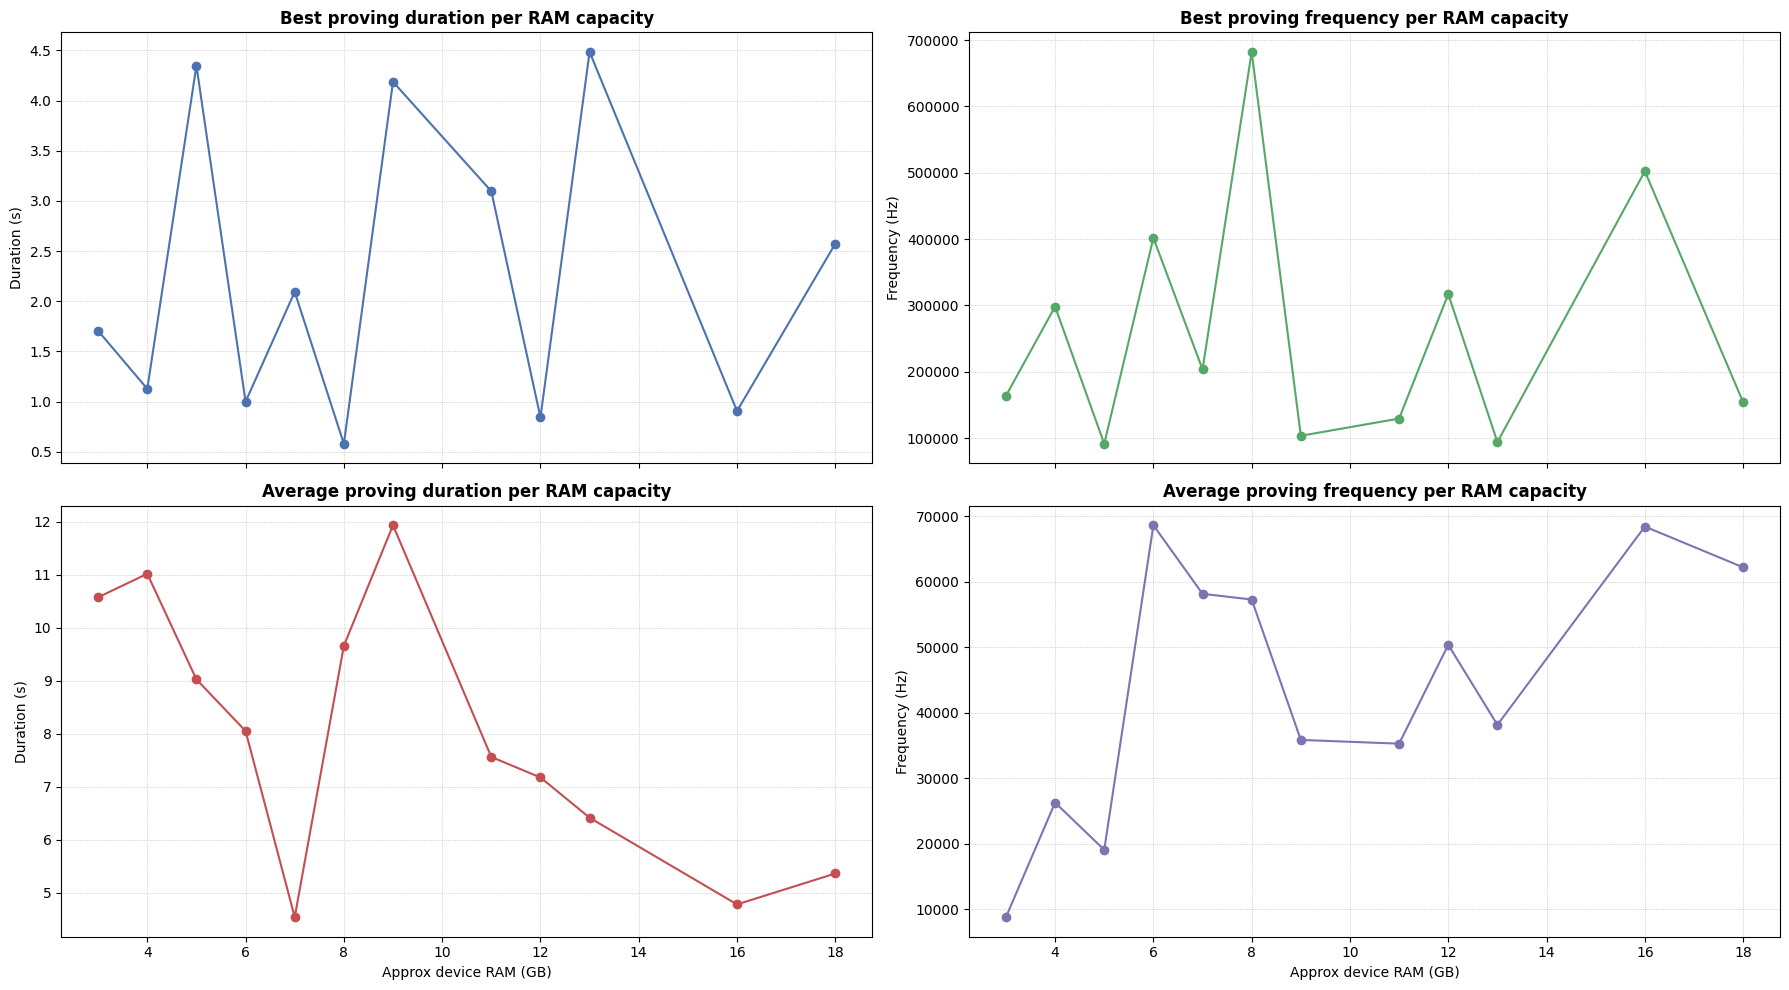

In [ ]:
import numpy as np
from matplotlib.ticker import MaxNLocator

ram_bucket_expr = (
    pl.when(
        pl.col("total_memory_bytes").is_not_null()
        & (pl.col("total_memory_bytes") > 0)
    )
    .then(
        (pl.col("total_memory_bytes") / 1_000_000_000)
        .round(0)
        .cast(pl.Int64)
    )
    .otherwise(None)
    .alias("ram_gb")
)

player_with_ram = (
    player_perf_enriched
    .with_columns(ram_bucket_expr)
    .filter(pl.col("ram_gb").is_not_null())
)

if player_with_ram.height == 0:
    print("No RAM data available for proving metrics.")
else:
    ram_metrics = (
        player_with_ram
        .group_by("ram_gb")
        .agg([
            pl.col("best_duration_s")
            .filter(
                pl.col("best_duration_s").is_not_null()
                & (pl.col("best_duration_s") > 0)
            )
            .min()
            .alias("best_duration_s"),
            pl.col("best_frequency_hz")
            .filter(
                pl.col("best_frequency_hz").is_not_null()
                & (pl.col("best_frequency_hz") > 0)
            )
            .max()
            .alias("best_frequency_hz"),
            pl.col("avg_frequency_hz")
            .filter(
                pl.col("avg_frequency_hz").is_not_null()
                & (pl.col("avg_frequency_hz") > 0)
            )
            .mean()
            .alias("avg_frequency_hz"),
            pl.col("avg_duration_s")
            .filter(
                pl.col("avg_duration_s").is_not_null()
                & (pl.col("avg_duration_s") > 0)
            )
            .mean()
            .alias("avg_duration_s"),
            pl.len().alias("player_count"),
        ])
        .sort("ram_gb")
    )

    if ram_metrics.height == 0:
        print("No proving metrics available per RAM capacity.")
    else:
        ram_labels = ram_metrics["ram_gb"].to_numpy()
        best_duration = np.array([
            float(value) if value is not None else np.nan
            for value in ram_metrics["best_duration_s"].to_list()
        ], dtype=float)
        best_frequency = np.array([
            float(value) if value is not None else np.nan
            for value in ram_metrics["best_frequency_hz"].to_list()
        ], dtype=float)
        avg_frequency = np.array([
            float(value) if value is not None else np.nan
            for value in ram_metrics["avg_frequency_hz"].to_list()
        ], dtype=float)
        avg_duration = np.array([
            float(value) if value is not None else np.nan
            for value in ram_metrics["avg_duration_s"].to_list()
        ], dtype=float)

        fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharex=True)
        axes = axes.ravel()

        axes[0].plot(
            ram_labels,
            best_duration,
            marker="o",
            linestyle="-",
            color="#4C72B0",
            linewidth=1.5,
        )
        axes[0].set_title("Best proving duration per RAM capacity")
        axes[0].set_ylabel("Duration (s)")
        axes[0].grid(True, axis="both", linestyle=":", linewidth=0.5)

        axes[1].plot(
            ram_labels,
            best_frequency,
            marker="o",
            linestyle="-",
            color="#55A868",
            linewidth=1.5,
        )
        axes[1].set_title("Best proving frequency per RAM capacity")
        axes[1].set_ylabel("Frequency (Hz)")
        axes[1].grid(True, axis="both", linestyle=":", linewidth=0.5)

        axes[2].plot(
            ram_labels,
            avg_duration,
            marker="o",
            linestyle="-",
            color="#C44E52",
            linewidth=1.5,
        )
        axes[2].set_title("Average proving duration per RAM capacity")
        axes[2].set_xlabel("Approx device RAM (GB)")
        axes[2].set_ylabel("Duration (s)")
        axes[2].grid(True, axis="both", linestyle=":", linewidth=0.5)

        axes[3].plot(
            ram_labels,
            avg_frequency,
            marker="o",
            linestyle="-",
            color="#8172B2",
            linewidth=1.5,
        )
        axes[3].set_title("Average proving frequency per RAM capacity")
        axes[3].set_xlabel("Approx device RAM (GB)")
        axes[3].set_ylabel("Frequency (Hz)")
        axes[3].grid(True, axis="both", linestyle=":", linewidth=0.5)

        for ax in axes:
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))

        plt.tight_layout()


#### Player & Device proving duration over RAM capacity

Panel A shows each player's best proof generation duration distributed per device RAM capacity ; Multiple players could have the same device: Panel B rolls that up to the top-performing player for the given device.

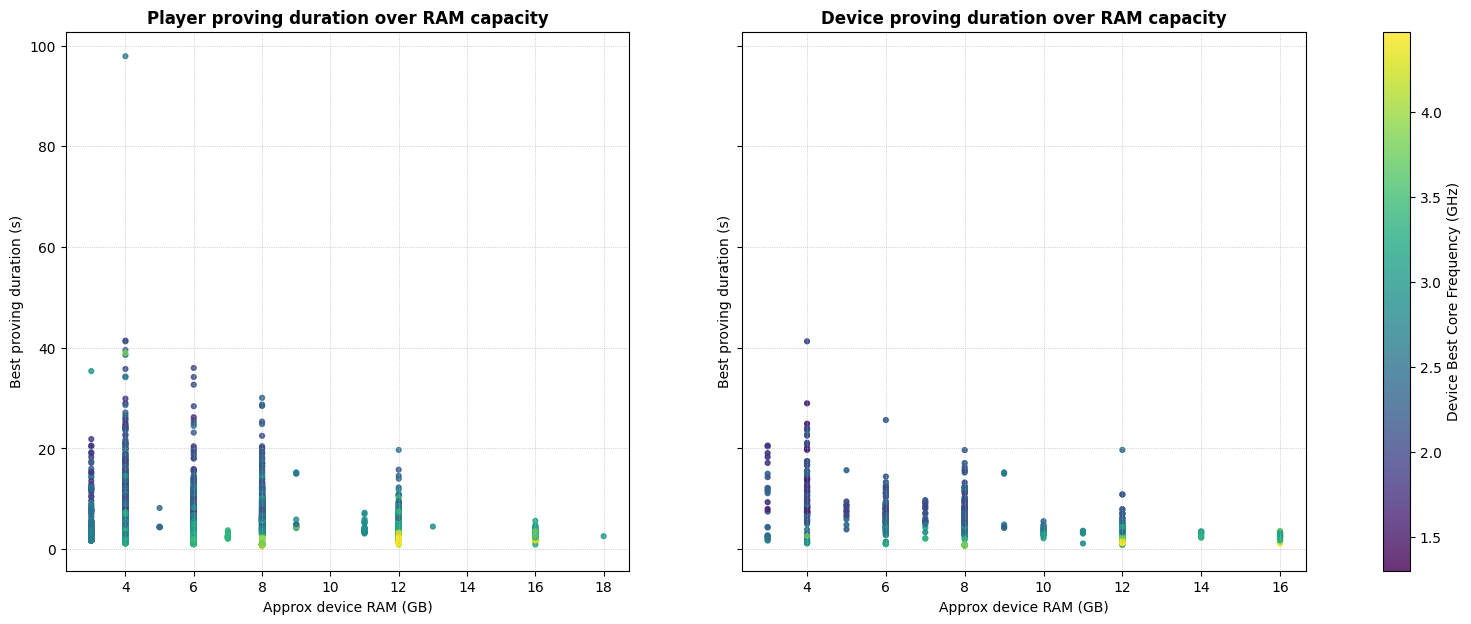

In [ ]:
player_duration_ram = (
    player_with_ram
    .filter(pl.col("best_duration_s").is_not_null())
    .filter(pl.col("best_duration_s") > 0)
    .filter(pl.col("best_core_freq_ghz").is_not_null())
    .select([
        "playerId",
        "marketing_name",
        "ram_gb",
        "best_duration_s",
        "avg_duration_s",
        "best_core_freq_ghz",
    ])
)

if player_duration_ram.height == 0:
    print("No player duration records with RAM capacitys.")
else:
    ram_players = player_duration_ram["ram_gb"].to_numpy()
    player_best_duration = player_duration_ram["best_duration_s"].to_numpy()
    player_core_freq = player_duration_ram["best_core_freq_ghz"].to_numpy()

    device_duration_ram = (
        player_duration_ram
        .filter(pl.col("marketing_name").is_not_null())
        .group_by("marketing_name")
        .agg([
            pl.col("ram_gb").drop_nulls().median().round(0).cast(pl.Int64).alias("ram_gb"),
            pl.col("best_duration_s").min().alias("best_duration_s"),
            pl.col("best_core_freq_ghz").max().alias("best_core_freq_ghz"),
        ])
        .filter(pl.col("ram_gb").is_not_null())
        .sort("ram_gb")
    )

    fig, duration_axes = plt.subplots(1, 2, figsize=(20, 7), sharey=True)

    color_min = float(np.min(player_core_freq)) if player_core_freq.size else 0.0
    color_max = float(np.max(player_core_freq)) if player_core_freq.size else 0.0
    device_core_freq = np.array([], dtype=float)
    if device_duration_ram.height > 0:
        device_core_freq = device_duration_ram["best_core_freq_ghz"].to_numpy()
        if device_core_freq.size:
            color_min = min(color_min, float(np.min(device_core_freq)))
            color_max = max(color_max, float(np.max(device_core_freq)))

    if color_min == color_max:
        color_max = color_min + 1e-6

    scatter_players = duration_axes[0].scatter(
        ram_players,
        player_best_duration,
        c=player_core_freq,
        cmap="viridis",
        vmin=color_min,
        vmax=color_max,
        alpha=0.8,
        s=12,
    )
    duration_axes[0].set_title("Player proving duration over RAM capacity")
    duration_axes[0].set_xlabel("Approx device RAM (GB)")
    duration_axes[0].set_ylabel("Best proving duration (s)")
    duration_axes[0].grid(True, axis="both", linestyle=":", linewidth=0.5)
    duration_axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))

    if device_duration_ram.height == 0:
        duration_axes[1].set_title("Device proving duration over RAM capacity")
        duration_axes[1].set_xlabel("Approx device RAM (GB)")
        duration_axes[1].set_ylabel("Best proving duration (s)")
        duration_axes[1].grid(True, axis="both", linestyle=":", linewidth=0.5)
        duration_axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
        duration_axes[1].text(0.5, 0.5, "No device-level data", ha="center", va="center")
    else:
        ram_devices = device_duration_ram["ram_gb"].to_numpy()
        device_best_duration = device_duration_ram["best_duration_s"].to_numpy()
        duration_axes[1].scatter(
            ram_devices,
            device_best_duration,
            c=device_core_freq,
            cmap="viridis",
            vmin=color_min,
            vmax=color_max,
            alpha=0.9,
            s=12,
        )
        duration_axes[1].set_title("Device proving duration over RAM capacity")
        duration_axes[1].set_xlabel("Approx device RAM (GB)")
        duration_axes[1].set_ylabel("Best proving duration (s)")
        duration_axes[1].grid(True, axis="both", linestyle=":", linewidth=0.5)
        duration_axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))

    fig.colorbar(
        scatter_players,
        ax=duration_axes.ravel().tolist(),
        label="Device Best Core Frequency (GHz)",
    )
    plt.show()

#### Player & Device proving frequency over RAM capacity
Panels mirror the duration view, but focus on highest frequency proofs: fastest while wheighting the computational workload.

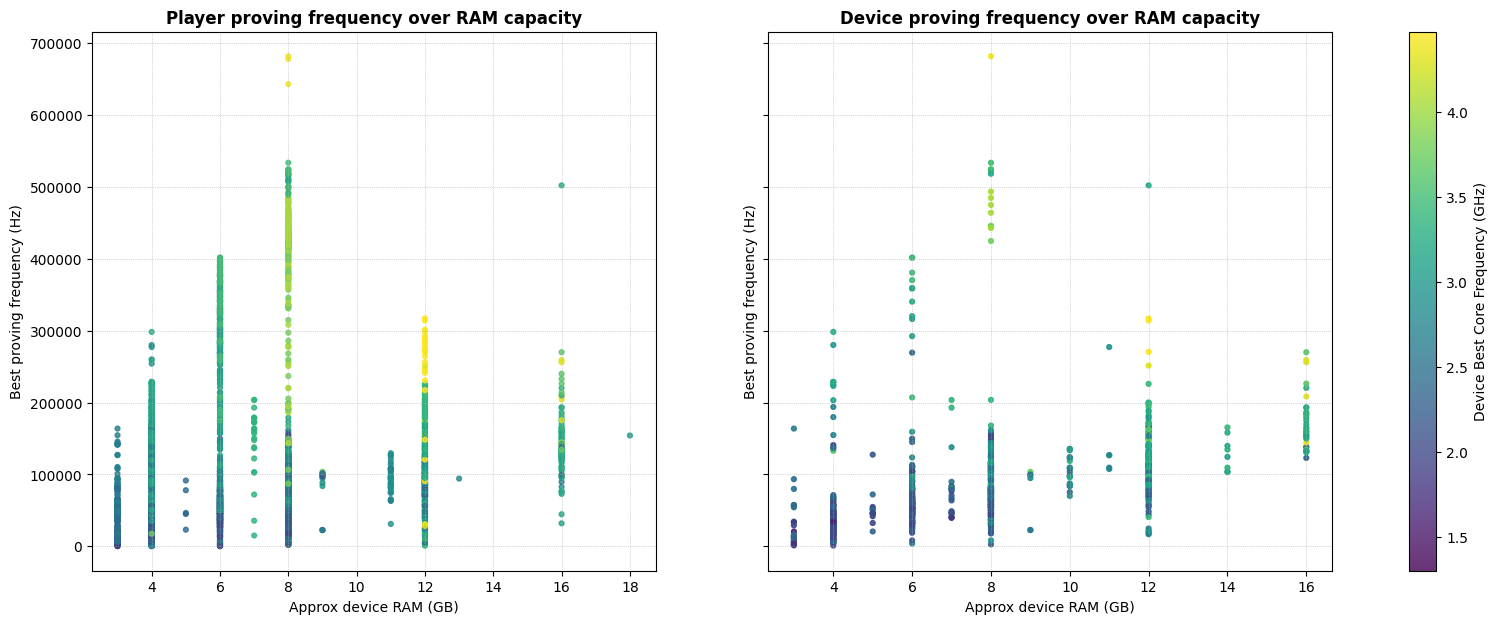

In [ ]:
player_frequency_ram = (
    player_with_ram
    .filter(pl.col("best_frequency_hz").is_not_null())
    .filter(pl.col("best_frequency_hz") > 0)
    .filter(pl.col("best_core_freq_ghz").is_not_null())
    .select([
        "playerId",
        "marketing_name",
        "ram_gb",
        "best_frequency_hz",
        "avg_frequency_hz",
        "best_core_freq_ghz",
    ])
)

if player_frequency_ram.height == 0:
    print("No player frequency records with RAM capacitys.")
else:
    ram_players = player_frequency_ram["ram_gb"].to_numpy()
    player_best_freq = player_frequency_ram["best_frequency_hz"].to_numpy()
    player_core_freq = player_frequency_ram["best_core_freq_ghz"].to_numpy()

    device_frequency_ram = (
        player_frequency_ram
        .filter(pl.col("marketing_name").is_not_null())
        .group_by("marketing_name")
        .agg([
            pl.col("ram_gb").drop_nulls().median().round(0).cast(pl.Int64).alias("ram_gb"),
            pl.col("best_frequency_hz").max().alias("best_frequency_hz"),
            pl.col("best_core_freq_ghz").max().alias("best_core_freq_ghz"),
        ])
        .filter(pl.col("ram_gb").is_not_null())
        .sort("ram_gb")
    )

    fig, freq_axes = plt.subplots(1, 2, figsize=(20, 7), sharey=True)

    color_min = float(np.min(player_core_freq)) if player_core_freq.size else 0.0
    color_max = float(np.max(player_core_freq)) if player_core_freq.size else 0.0

    device_core_freq = np.array([], dtype=float)
    if device_frequency_ram.height > 0:
        device_core_freq = device_frequency_ram["best_core_freq_ghz"].to_numpy()
        if device_core_freq.size:
            color_min = min(color_min, float(np.min(device_core_freq)))
            color_max = max(color_max, float(np.max(device_core_freq)))

    if color_min == color_max:
        color_max = color_min + 1e-6

    scatter_players = freq_axes[0].scatter(
        ram_players,
        player_best_freq,
        c=player_core_freq,
        cmap="viridis",
        vmin=color_min,
        vmax=color_max,
        alpha=0.8,
        s=12,
    )
    freq_axes[0].set_title("Player proving frequency over RAM capacity")
    freq_axes[0].set_xlabel("Approx device RAM (GB)")
    freq_axes[0].set_ylabel("Best proving frequency (Hz)")
    freq_axes[0].grid(True, axis="both", linestyle=":", linewidth=0.5)
    freq_axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))

    if device_frequency_ram.height == 0:
        freq_axes[1].set_title("Device proving frequency over RAM capacity")
        freq_axes[1].set_xlabel("Approx device RAM (GB)")
        freq_axes[1].set_ylabel("Best proving frequency (Hz)")
        freq_axes[1].grid(True, axis="both", linestyle=":", linewidth=0.5)
        freq_axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
        freq_axes[1].text(0.5, 0.5, "No device-level data", ha="center", va="center")
    else:
        ram_devices = device_frequency_ram["ram_gb"].to_numpy()
        device_best_freq = device_frequency_ram["best_frequency_hz"].to_numpy()
        scatter_devices = freq_axes[1].scatter(
            ram_devices,
            device_best_freq,
            c=device_core_freq,
            cmap="viridis",
            vmin=color_min,
            vmax=color_max,
            alpha=0.9,
            s=12,
        )
        freq_axes[1].set_title("Device proving frequency over RAM capacity")
        freq_axes[1].set_xlabel("Approx device RAM (GB)")
        freq_axes[1].set_ylabel("Best proving frequency (Hz)")
        freq_axes[1].grid(True, axis="both", linestyle=":", linewidth=0.5)
        freq_axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))

    fig.colorbar(
        scatter_players,
        ax=freq_axes.ravel().tolist(),
        label="Device Best Core Frequency (GHz)",
    )
    plt.show()

## Crash Analysis

Combine crash logs with performance metrics to estimate failure rates and identify unstable hardware.


In [40]:
crash_per_player = (
    crash_lf
    .group_by("playerId")
    .agg([
        pl.len().alias("crash_events"),
        pl.col("n").median().alias("median_n_crash"),
        pl.col("reported_at").min().alias("first_crash_at"),
        pl.col("reported_at").max().alias("last_crash_at"),
    ])
    .collect()
)

player_reliability = (
    player_perf_enriched
    .join(crash_per_player, on="playerId", how="left")
    .with_columns([
        pl.col("crash_events").fill_null(0).cast(pl.Int64),
        pl.col("median_n_crash").alias("median_n_crash"),
        safe_ratio(pl.col("crash_events"), pl.col("proof_count"), "crash_per_proof"),
    ])
    .sort("crash_per_proof", descending=True)
)


### Players With Frequent Crashes

Focus on players with at least three incidents to surface high-risk accounts.


In [41]:
high_risk_players = (
    player_reliability
    .filter(pl.col("crash_events") >= 3)
    .with_columns([(pl.col("total_memory_bytes") / 1_000_000_000).round(0).cast(pl.Int64).alias("ram_gb")])
    .select([
        "playerId",
        "marketing_name",
        "ram_gb",
        "proof_count",
        "crash_events",
        "crash_per_proof",
        "avg_duration_s",
        "avg_frequency_hz",
        "model_name"
    ])
    .sort("crash_events", descending=True)
    .head(10)
)

high_risk_players


shape: (10, 9)
┌──────────────────────────────────┬───────────────────────┬────────┬─────────────┬──────────────┬─────────────────┬────────────────┬──────────────────┬───────────────────────────┐
│ playerId                         ┆ marketing_name        ┆ ram_gb ┆ proof_count ┆ crash_events ┆ crash_per_proof ┆ avg_duration_s ┆ avg_frequency_hz ┆ model_name                │
│ ---                              ┆ ---                   ┆ ---    ┆ ---         ┆ ---          ┆ ---             ┆ ---            ┆ ---              ┆ ---                       │
│ str                              ┆ str                   ┆ i64    ┆ i64         ┆ i64          ┆ f64             ┆ f64            ┆ f64              ┆ str                       │
╞══════════════════════════════════╪═══════════════════════╪════════╪═════════════╪══════════════╪═════════════════╪════════════════╪══════════════════╪═══════════════════════════╡
│ kd78z6zmdtfm4nss0661bk7jvh7qdsvy ┆ Apple iPhone 13       ┆ 4      ┆ 868         ┆ 27           ┆ 0.031           ┆ 2.399          ┆ 20188.755        ┆ iPhone 13                 │
│ kd72et0bp4z8qnvf708csgs4f97qezhv ┆ Apple iPhone 13 mini  ┆ 4      ┆ 742         ┆ 25           ┆ 0.034           ┆ 2.946          ┆ 30264.611        ┆ iPhone 13 mini            │
│ kd76w9jc81g9t7ngk0xxzf6awx7qfeb6 ┆ Apple iPhone 8 Plus   ┆ 3      ┆ 587         ┆ 24           ┆ 0.041           ┆ 7.613          ┆ 9324.041         ┆ iPhone 8 Plus             │
│ kd7cgh8etsc2ek8j0rttjgzfn97qgfva ┆ Apple iPhone 12       ┆ 4      ┆ 744         ┆ 24           ┆ 0.032           ┆ 1.653          ┆ 31365.053        ┆ iPhone 12                 │
│ kd74jbnhte6szxsjsy2x9n0d1x7qe5t1 ┆ Apple iPad Air (2019) ┆ 3      ┆ 252         ┆ 22           ┆ 0.087           ┆ 3.020          ┆ 9858.575         ┆ iPad Air (3rd generation) │
│ kd7fynb0gg3rgrafw02dyaq6157qg0x1 ┆ Apple iPhone 13       ┆ 4      ┆ 551         ┆ 22           ┆ 0.040           ┆ 2.891          ┆ 23468.677        ┆ iPhone 13                 │
│ kd7cn26xgw4fey4e6am6tczvr57qn8t4 ┆ Apple iPhone 11       ┆ 4      ┆ 701         ┆ 22           ┆ 0.031           ┆ 2.036          ┆ 17181.740        ┆ iPhone 11                 │
│ kd7596eh7aegh0fmd7t5pctn7d7qgf9d ┆ Apple iPhone XR       ┆ 3      ┆ 96          ┆ 21           ┆ 0.219           ┆ 10.348         ┆ 1674.688         ┆ iPhone XR                 │
│ kd75r0mrte74hqbb81ycaa911x7qgwdm ┆ Apple iPhone 13       ┆ 4      ┆ 661         ┆ 21           ┆ 0.032           ┆ 1.935          ┆ 28633.553        ┆ iPhone 13                 │
│ kd76fx2ggcj1gfzhp46yp0r5r97qhfb2 ┆ Apple iPhone 12 mini  ┆ 4      ┆ 673         ┆ 21           ┆ 0.031           ┆ 2.104          ┆ 27895.699        ┆ iPhone 12 mini            │
└──────────────────────────────────┴───────────────────────┴────────┴─────────────┴──────────────┴─────────────────┴────────────────┴──────────────────┴───────────────────────────┘

### Device Stability Snapshot

Crash counts aggregated by device provide a hardware view of reliability issues.

Most crashes happened on devices being about 5 years old.


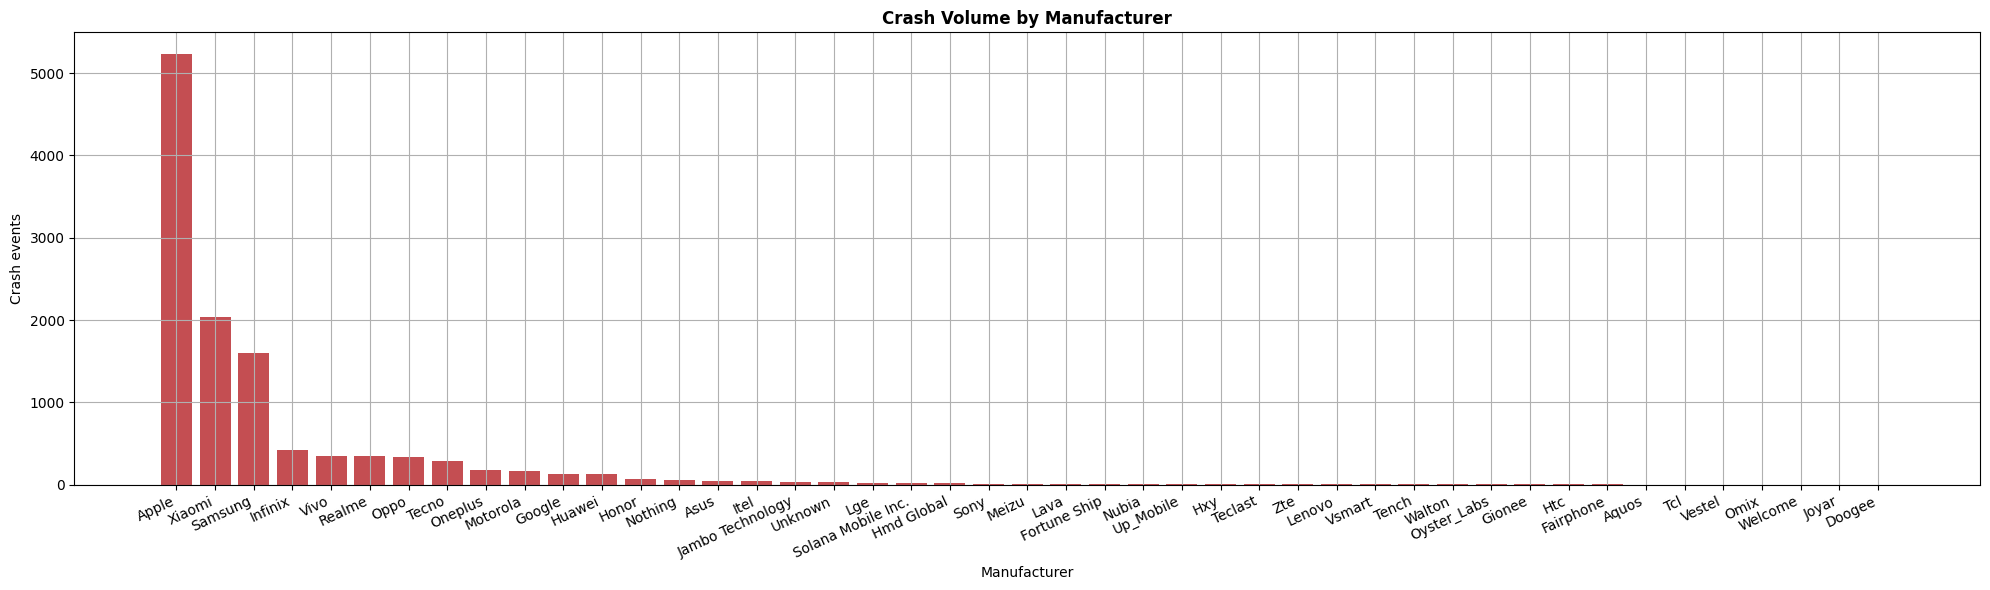

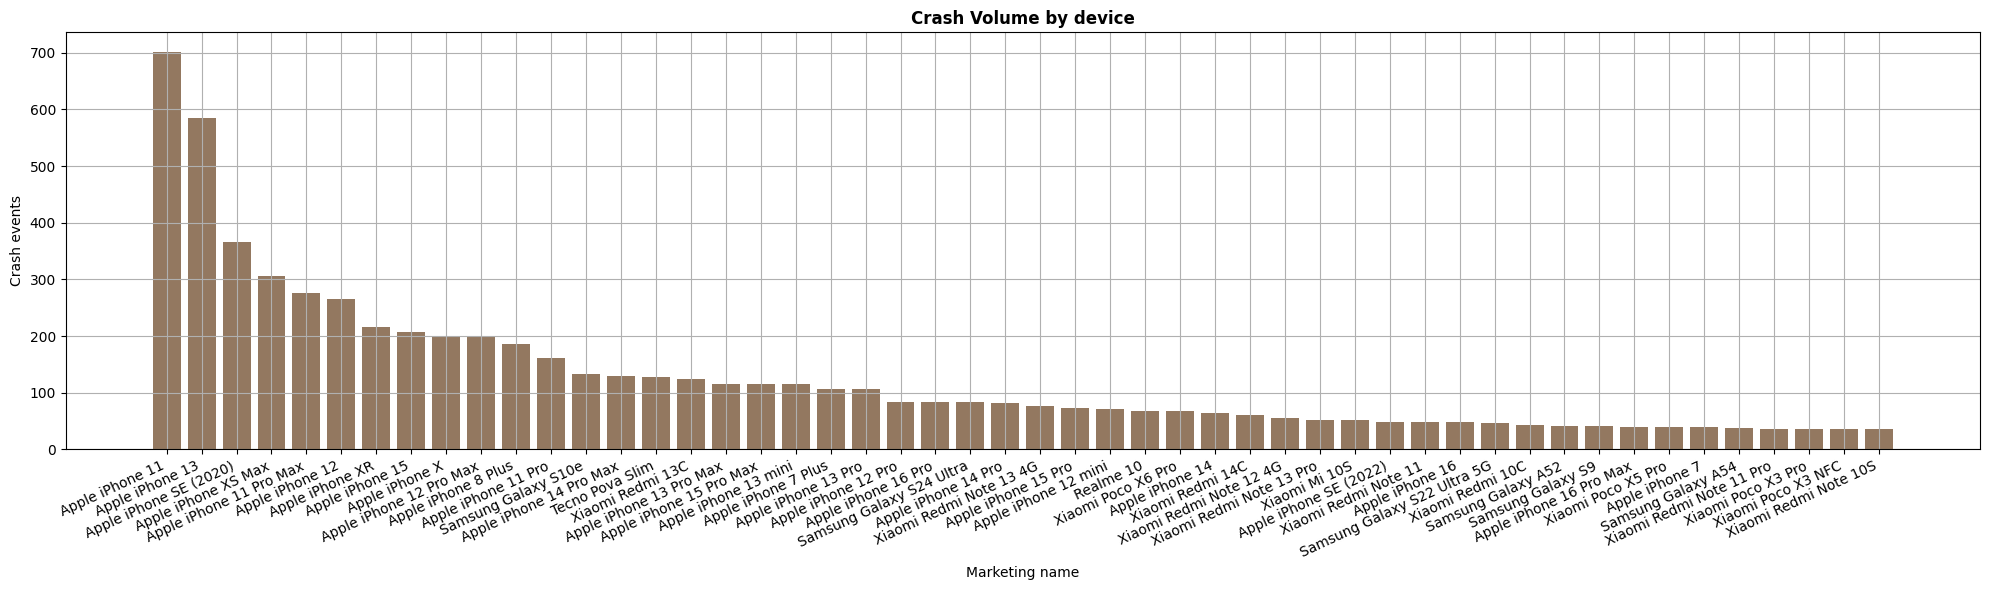

In [37]:
devices_for_join = devices_lf.select([
    pl.col("_id").alias("deviceId"),
    pl.col("playerId").alias("device_owner"),
    pl.col("manufacturer"),
    pl.col("model_name"),
    pl.col("marketing_name"),
    pl.col("os_name"),
    pl.col("device_type"),
    pl.col("device_year_class"),
    pl.col("total_memory_bytes"),
])

crash_device = crash_lf.join(devices_for_join, on="deviceId", how="left")

crash_device_summary = (
    crash_device
    .group_by(["manufacturer", "model_name", "os_name"])
    .agg([
        pl.len().alias("crash_events"),
        pl.col("n").median().alias("median_n"),
    ])
    .sort("crash_events", descending=True)
    .collect()
)

crash_device_summary

top_crash_manufacturer = (
    crash_device
    .group_by("manufacturer")
    .agg(pl.len().alias("crash_events"))
    .sort("crash_events", descending=True)
    .collect()
    .with_columns([
        pl.col("manufacturer").fill_null("Unknown"),
    ])
)

null_manufacturer_crashes = (
    crash_device
    .filter(pl.col("manufacturer").is_null())
    .group_by("deviceId")
    .agg(pl.len().alias("crash_events"))
    .sort("crash_events", descending=True)
    .collect()
)


crash_manufacturers = top_crash_manufacturer["manufacturer"].to_list()
crash_counts = top_crash_manufacturer["crash_events"].to_list()

plt.figure(figsize=(20, 6))
plt.bar(crash_manufacturers, crash_counts, color="#C44E52")
plt.title("Crash Volume by Manufacturer")
plt.xlabel("Manufacturer")
plt.ylabel("Crash events")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()


crash_by_marketing_name = (
    crash_device
    .group_by("marketing_name")
    .agg(pl.len().alias("crash_events"))
    .sort("crash_events", descending=True)
    .head(50)
    .collect()
    .with_columns([
        pl.col("marketing_name").fill_null("Unknown"),
    ])
)

marketing_labels = crash_by_marketing_name["marketing_name"].to_list()
marketing_counts = crash_by_marketing_name["crash_events"].to_list()

plt.figure(figsize=(20, 6))
plt.bar(marketing_labels, marketing_counts, color="#937860")
plt.title("Crash Volume by device")
plt.xlabel("Marketing name")
plt.ylabel("Crash events")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()


### Crash Patterns by Device RAM
Crash counts bucketed by approximate device memory (GB).

Devices with less than 3 GB of RAM didn't succeed to generate a single proof.
Devices with 3 and 4 GB of RAM were the most prone to crashes, due to the memory footprint of Cairo M and the underlying prover S-two when generating a proof.

/var/folders/m8/nz6glvyx63zf7jbhjpmjhclr0000gn/T/ipykernel_84177/4044244680.py:5: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  if "total_memory_bytes" not in crash_with_ram.columns or "device_owner" not in crash_with_ram.columns:
/var/folders/m8/nz6glvyx63zf7jbhjpmjhclr0000gn/T/ipykernel_84177/4044244680.py:73: DeprecationWarning: use of `how='outer'` should be replaced with `how='full'`.
(Deprecated in version 0.20.29)
  .join(player_counts, on="ram_gb", how="outer", suffix="_player")
/var/folders/m8/nz6glvyx63zf7jbhjpmjhclr0000gn/T/ipykernel_84177/4044244680.py:74: DeprecationWarning: use of `how='outer'` should be replaced with `how='full'`.
(Deprecated in version 0.20.29)
  .join(proofs_by_ram, on="ram_gb", how="outer", suffix="_proofs")
/var/folders/m8/nz6glvyx63zf7jbhjpmjhclr0000gn/T/ipykernel_84177/

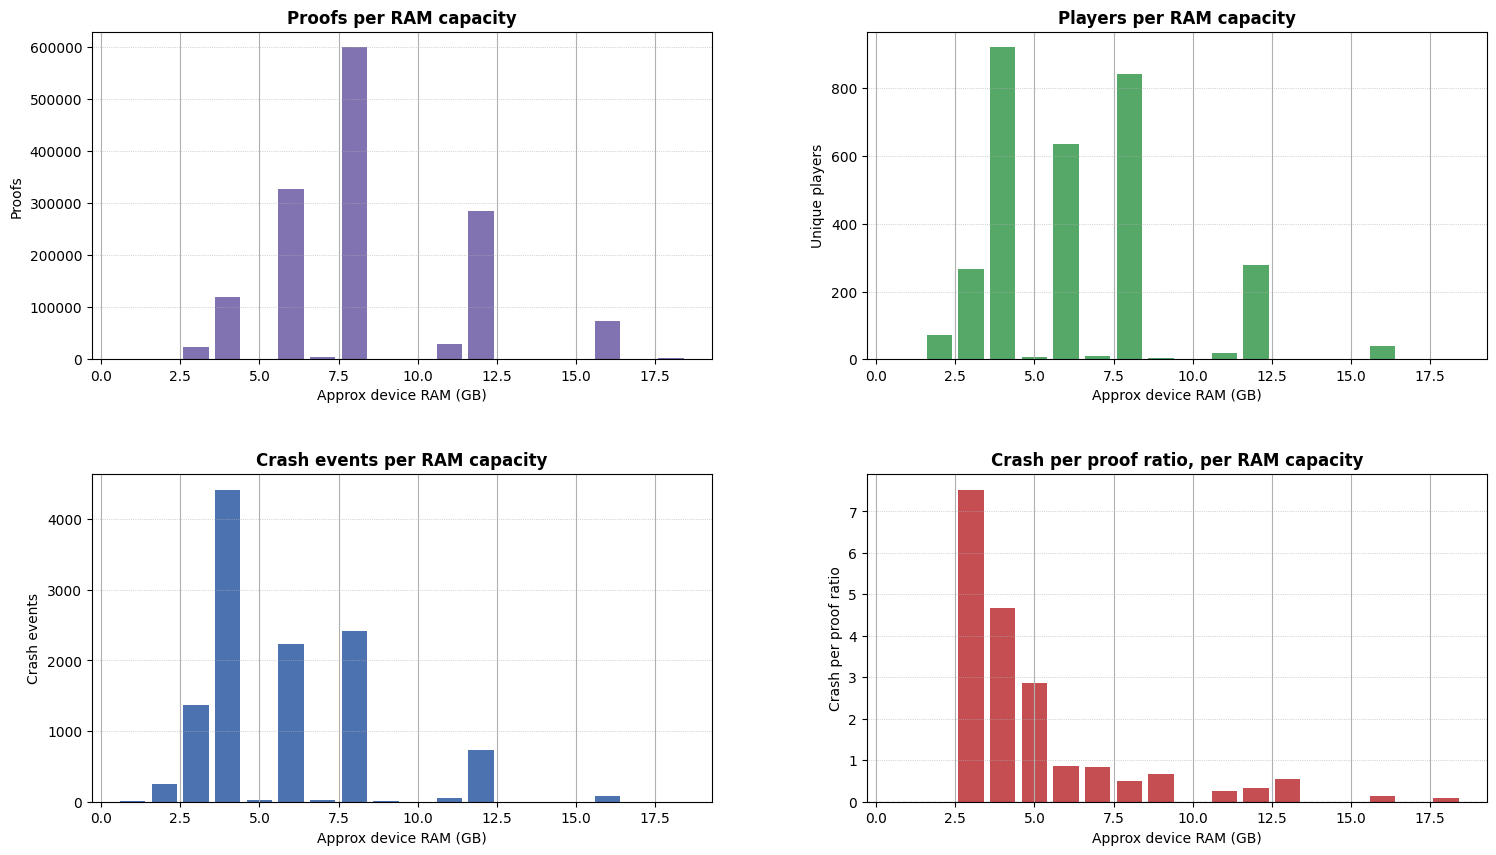

In [ ]:
import numpy as np
from matplotlib.ticker import PercentFormatter

crash_with_ram = crash_device
if "total_memory_bytes" not in crash_with_ram.columns or "device_owner" not in crash_with_ram.columns:
    crash_with_ram = crash_with_ram.join(
        devices_lf.select([
            pl.col("_id").alias("deviceId"),
            pl.col("total_memory_bytes"),
            pl.col("playerId").alias("device_owner"),
        ]),
        on="deviceId",
        how="left",
    )

crash_with_ram_lf = (
    crash_with_ram
    .with_columns([
        pl.when(
            pl.col("total_memory_bytes").is_not_null()
            & (pl.col("total_memory_bytes") > 0)
        )
        .then(
            (pl.col("total_memory_bytes") / 1_000_000_000)
            .round(0)
            .cast(pl.Int64)
        )
        .otherwise(None)
        .alias("ram_gb"),
    ])
    .filter(pl.col("ram_gb").is_not_null())
)

crash_with_ram = crash_with_ram_lf.collect()

if crash_with_ram.height == 0:
    print("No RAM data available for crash analysis.")
else:
    crash_counts = (
        crash_with_ram
        .group_by("ram_gb")
        .agg(pl.len().alias("crash_events"))
    )

    players_by_ram = (
        crash_with_ram
        .select(["device_owner", "ram_gb"])
        .filter(pl.col("device_owner").is_not_null())
        .unique()
    )

    player_counts = (
        players_by_ram
        .group_by("ram_gb")
        .agg(pl.len().alias("players_with_crash"))
    )

    proofs_by_ram = (
        players_by_ram
        .join(
            player_perf_enriched.select(["playerId", "proof_count"]),
            left_on="device_owner",
            right_on="playerId",
            how="left",
        )
        .with_columns(pl.col("proof_count").fill_null(0))
        .group_by("ram_gb")
        .agg(pl.col("proof_count").sum().cast(pl.Int64).alias("total_proofs"))
    )

    ram_summary = (
        crash_counts
        .join(player_counts, on="ram_gb", how="outer", suffix="_player")
        .join(proofs_by_ram, on="ram_gb", how="outer", suffix="_proofs")
        .fill_null(0)
        .sort("ram_gb")
    )

    ram_labels = ram_summary["ram_gb"].to_numpy()
    crash_counts = ram_summary["crash_events"].to_numpy()
    player_counts = ram_summary["players_with_crash"].to_numpy()
    proof_counts = ram_summary["total_proofs"].to_numpy()

    crash_share = crash_counts.astype(float)
    total_crashes = crash_share.sum()
    if total_crashes:
        crash_share /= total_crashes
    else:
        crash_share.fill(0)

    proof_share = proof_counts.astype(float)
    total_proofs = proof_share.sum()
    if total_proofs:
        proof_share /= total_proofs
    else:
        proof_share.fill(0)

    crash_to_proof_ratio = np.divide(
        crash_share,
        proof_share,
        out=np.zeros(len(ram_labels), dtype=float),
        where=proof_share != 0,
    )

    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], hspace=0.35, wspace=0.25)

    ax_proofs = fig.add_subplot(gs[0, 0])
    ax_players = fig.add_subplot(gs[0, 1], sharex=ax_proofs)
    ax_crash = fig.add_subplot(gs[1, 0], sharex=ax_proofs)
    ax_percent = fig.add_subplot(gs[1, 1], sharex=ax_proofs)

    ax_players.bar(ram_labels, player_counts, color="#55A868")
    ax_players.set_title("Players per RAM capacity")
    ax_players.set_xlabel("Approx device RAM (GB)")
    ax_players.set_ylabel("Unique players")
    ax_players.grid(True, axis="y", linestyle=":", linewidth=0.5)

    ax_proofs.bar(ram_labels, proof_counts, color="#8172B2")
    ax_proofs.set_title("Proofs per RAM capacity")
    ax_proofs.set_xlabel("Approx device RAM (GB)")
    ax_proofs.set_ylabel("Proofs")
    ax_proofs.grid(True, axis="y", linestyle=":", linewidth=0.5)

    ax_crash.bar(ram_labels, crash_counts, color="#4C72B0")
    ax_crash.set_title("Crash events per RAM capacity")
    ax_crash.set_xlabel("Approx device RAM (GB)")
    ax_crash.set_ylabel("Crash events")
    ax_crash.grid(True, axis="y", linestyle=":", linewidth=0.5)

    ax_percent.bar(ram_labels, crash_to_proof_ratio, color="#C44E52")
    ax_percent.axhline(color="black", linestyle="--", linewidth=0.8)
    ax_percent.set_title("Crash per proof ratio, per RAM capacity")
    ax_percent.set_xlabel("Approx device RAM (GB)")
    ax_percent.set_ylabel("Crash per proof ratio")
    ax_percent.grid(True, axis="y", linestyle=":", linewidth=0.5)

    plt.tight_layout()
    plt.show()


## Temporal Trends

Hourly aggregates highlight seasonality, onboarding spikes, and crash/throughput divergence over time.


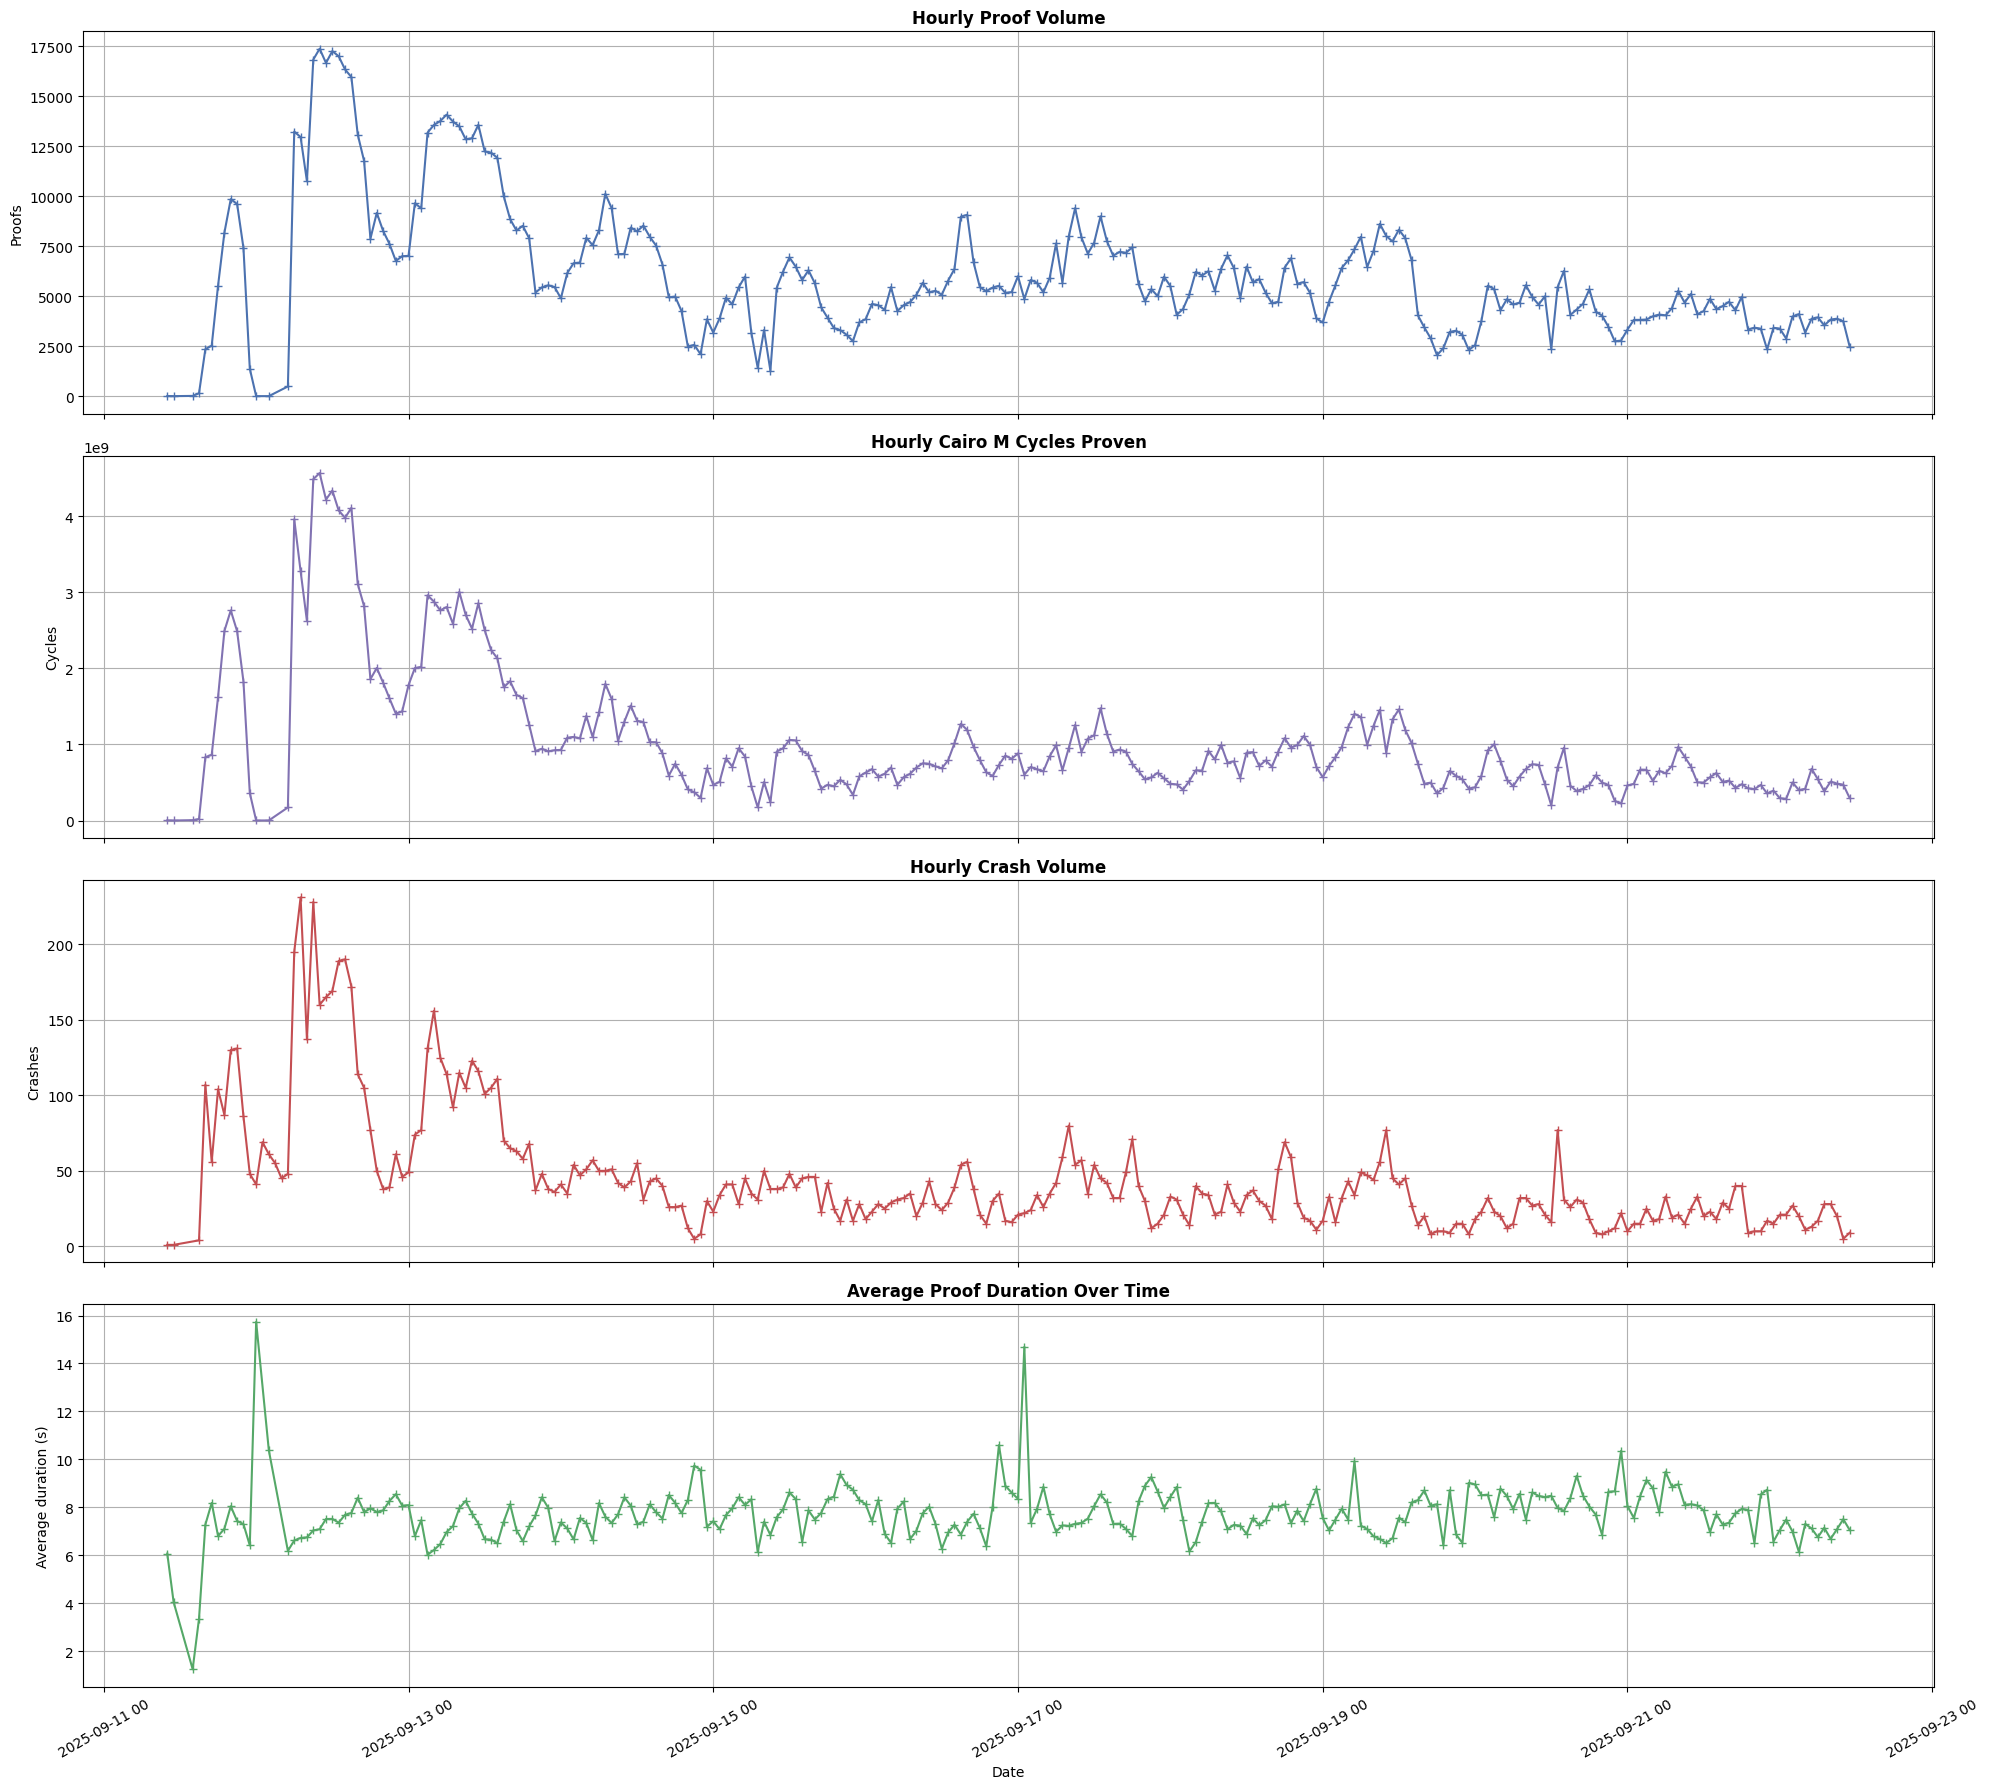

In [38]:
minted_hourly = (
    minted_lf
    .with_columns([pl.col("minted_at").dt.truncate("1h").alias("minted_window")])
    .group_by("minted_window")
    .agg([
        pl.len().alias("proofs"),
        pl.col("n").fill_null(0).sum().mul(8).alias("total_cycles"),
        pl.col("overallDuration").mean().alias("avg_duration_s"),
        pl.col("overallFrequency").mean().alias("avg_frequency_hz"),
    ])
    .sort("minted_window")
    .collect()
)

crash_hourly = (
    crash_lf
    .with_columns([pl.col("reported_at").dt.truncate("1h").alias("reported_window")])
    .group_by("reported_window")
    .agg([
        pl.len().alias("crash_events"),
    ])
    .sort("reported_window")
    .collect()
)

fig, axes = plt.subplots(4, 1, figsize=(20, 18), sharex=True)

axes[0].plot(
    minted_hourly["minted_window"].to_list(),
    minted_hourly["proofs"].to_list(),
    marker="+",
    color="#4C72B0",
)
axes[0].set_title("Hourly Proof Volume")
axes[0].set_ylabel("Proofs")
axes[0].grid(True, which="major", axis="y")

axes[1].plot(
    minted_hourly["minted_window"].to_list(),
    minted_hourly["total_cycles"].to_list(),
    marker="+",
    color="#8172B2",
)
axes[1].set_title("Hourly Cairo M Cycles Proven")
axes[1].set_ylabel("Cycles")
axes[1].grid(True, which="major", axis="y")

axes[2].plot(
    crash_hourly["reported_window"].to_list(),
    crash_hourly["crash_events"].to_list(),
    marker="+",
    color="#C44E52",
)
axes[2].set_title("Hourly Crash Volume")
axes[2].set_ylabel("Crashes")
axes[2].grid(True, which="major", axis="y")

duration_trend = minted_hourly.select(["minted_window", "avg_duration_s"])

axes[3].plot(
    duration_trend["minted_window"].to_list(),
    duration_trend["avg_duration_s"].to_list(),
    marker="+",
    color="#55A868",
)
axes[3].set_title("Average Proof Duration Over Time")
axes[3].set_xlabel("Date")
axes[3].set_ylabel("Average duration (s)")
axes[3].grid(True, which="major", axis="y")
axes[3].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H"))
axes[3].tick_params(axis="x", rotation=30)

plt.tight_layout()
